## Importing libraries

In [83]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
import matplotlib.pyplot as plt # to make good visualizations
import seaborn as sns # to make good visualizations


## Reading datasets previously created

In [84]:
df_names = ['All', 'Top25', 'Top50', 'Top75', 'Side25', 'Side50', 'Side75']

In [85]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
all_anns_df = pd.read_csv('./data/coco_diff/All.csv')
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [86]:
all_anns_df

,Img,num_people,offset,face_avg_ratio,body_avg_ratio,extremities_avg_ratio,num_people_diff,people_size_diff,visibility_diff,offset_diff,total_dif
0,36,1,0.294100,1.000000,1.000000,0.500000,0.500000,0.720162,0.100000,0.294100,0.403566
1,49,6,0.363385,0.233333,0.291667,0.187500,0.857143,0.996770,0.758333,0.363385,0.743908
2,61,3,0.130800,0.000000,0.000000,0.000000,0.750000,0.997873,1.000000,0.130800,0.719668
3,74,6,0.340124,0.000000,0.000000,0.000000,0.857143,0.998416,1.000000,0.340124,0.798921
4,77,5,0.382953,0.200000,0.550000,0.575000,0.833333,0.983026,0.620000,0.382953,0.704828
...,...,...,...,...,...,...,...,...,...,...,...
58878,581886,3,0.357505,0.200000,0.666667,0.416667,0.750000,0.986880,0.616667,0.357505,0.677763
58879,581887,1,0.690295,0.500000,0.250000,0.000000,0.500000,0.990632,0.675000,0.690295,0.713982
58880,581899,3,0.115953,0.133333,0.000000,0.229167,0.750000,0.998169,0.887500,0.115953,0.687905
58881,581900,6,0.510639,0.166667,0.375000,0.364583,0.857143,0.985052,0.731250,0.510639,0.771021


In [87]:
all_predictions_df

,ID,Img_ID,Confidence,Format,x_center,y_center,width,height
0,3260,326,0.866764,rgb,0.519095,0.579268,0.565375,0.817304
1,11490,1149,0.881282,rgb,0.252400,0.301281,0.176131,0.383411
2,11491,1149,0.851260,rgb,0.927591,0.469189,0.143462,0.780830
3,11492,1149,0.804412,rgb,0.678745,0.470363,0.150654,0.718626
4,11493,1149,0.740676,rgb,0.845905,0.442369,0.101878,0.689938
...,...,...,...,...,...,...,...,...
5587,5811831,581183,0.793697,rgb,0.486329,0.759381,0.061583,0.286074
5588,5811832,581183,0.503064,rgb,0.249292,0.869054,0.111275,0.255515
5589,5811833,581183,0.321343,rgb,0.370138,0.217217,0.034143,0.138476
5590,5812780,581278,0.803501,rgb,0.462290,0.493127,0.642913,0.937107


<Axes: >

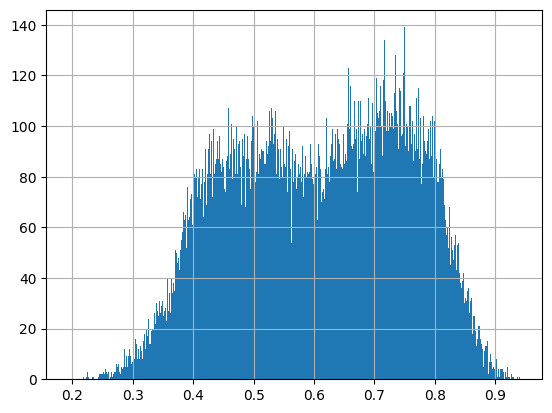

In [88]:
all_anns_df['total_dif'].hist(bins=1000)

Looking at the distribution, I can suggest four difficulty labels:
- Easy: images whose total_diff value is minor than 0.5
- Medium: images whose total_diff value is between 0.5 and 0.7
- Hard: images whose total_diff value is between 0.7 and 0.8
- Very Hard: images whose total_diff value is greater than 0.8

In [89]:
data = all_anns_df['total_dif'].sort_values()
easy = 0.5
medium = 0.7
hard = 0.8
easy_percent = float((data < easy).mean() * 100)
medium_percent = float(((data >= easy) & (data < medium)).mean() * 100)
hard_percent = float(((data >= medium) & (data < hard)).mean() * 100)
very_hard_percent = float((data >= hard).mean() * 100)

In [90]:
print(easy_percent)
print(medium_percent)
print(hard_percent)
print(very_hard_percent)

27.413684764702882
40.56688687736698
23.123821816143877
8.895606541786254


Here it's possible to see the percentiles the given value belong to. With this labeling we will have approximately the 27% of the data being considered as _easy_, 41% of the data considered as _medium_, 23% of the data considered as _hard_,  and 9% of the data being considered as _very hard_. 

In [91]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [92]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

## Precision

I chose 0.50 as arbitrary value to consider a detection as confident enough to be evaluated. This value is low, taking a look at the distribution of confidence among all detections and at the confidence value of wrongly detected people, so we can consider this value as the borderline confidence the model has to make assumptions.

<Axes: >

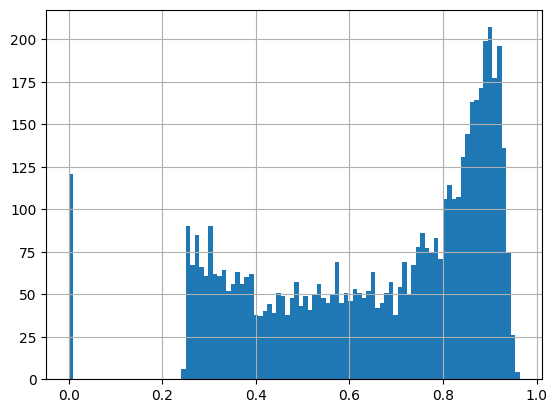

In [93]:
all_predictions_df['Confidence'].hist(bins=100)

In [94]:
def detect_on_threshold(df, threshold):
    df['detected'] = df['Confidence'].apply(lambda x: 1 if x>=threshold else 0)

In [95]:
detect_on_threshold(all_predictions_df, 0.5)

## Grouping

I grouped values based on Img_ID, aggregating confidence values with the mean and detected with the sum. In this way it is possible to have mean confidence and number of people detected in the image.

In [96]:
def group_predictions(df):
    return df.groupby('Img_ID').agg(
    {
        'Confidence': 'mean',
        'detected': 'sum',
        'Format': 'first'
    }
)

In [97]:
grouped_predictions_df = group_predictions(all_predictions_df)

In [99]:
df_out = pd.merge(all_anns_df, grouped_predictions_df, how='inner', left_on='Img', right_on='Img_ID')
df_out.set_index('Img', inplace=True)
df_pca = df_out.copy()
df_out = df_out[['Confidence', 'label', 'detected', 'num_people']]

I added 
- true positive values as the number of people detected correctly in the image
- false positive values as the number of people detected wrongly (the exceeding people detected)
- false negative values as the number of people not detected by the model

In [100]:
def adding_precision_feature(df):
    df.fillna({'detected': 0, 'Confidence': 0}, inplace=True)
    df['true_pos'] = np.minimum(df['detected'], df['num_people'])
    df['false_pos'] = np.maximum(df['detected'] - df['num_people'], 0)
    df['false_neg'] = np.maximum(df['num_people'] - df['detected'], 0)

Then I added some metrics to evaluate the model,
those are:
- accuracy, 1 for images where the detection has been perfect (number of people detected was the same as number of people in the image), 0 for the rest
- precision, as count of people well detected (who were in the image) over total of people detected, so how many detections were actually good over the total number of detection

- mae, mean absolute error (i.e. 3 for both 3 people detected in exceed or 3 people not detected)
- mse, mean squared error (to give more weight to very wrong detection)
- recall, number of well detected people over total number of people in the image
- f1-score, a combined version of both precision and recall

In [101]:
def adding_metrics_features(df):
    df['mae'] = np.abs(df['num_people']-df['detected'])
    df['mse'] = (df['num_people']-df['detected'])**2
    df['accuracy'] =(df['detected'] == df['num_people']).astype(int)
    df['precision'] = (df['true_pos']/(df['true_pos']+df['false_pos']))
    df['recall'] = (df['true_pos']/(df['true_pos']+df['false_neg']))
    df['f1-score'] = 2*((df['precision']*df['recall'])/(df['precision']+df['recall']))
    
    df.fillna({'precision': 0, 'recall': 0, 'f1-score': 0}, inplace=True)

In [102]:
adding_precision_feature(df_out)
adding_metrics_features(df_out)

In [103]:
df_out

,Confidence,label,detected,num_people,true_pos,false_pos,false_neg,mae,mse,accuracy,precision,recall,f1-score
Img,,,,,,,,,,,,,
326,0.866764,medium,1,1,1,0,0,0,0,1,1.0,1.00,1.000000
1149,0.607025,hard,9,12,9,0,3,3,9,0,1.0,0.75,0.857143
1200,0.739418,hard,3,3,3,0,0,0,0,1,1.0,1.00,1.000000
1319,0.431452,medium,0,1,0,0,1,1,1,0,0.0,0.00,0.000000
1900,0.000000,hard,0,1,0,0,1,1,1,0,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579891,0.909920,medium,1,1,1,0,0,0,0,1,1.0,1.00,1.000000
580781,0.841013,medium,1,1,1,0,0,0,0,1,1.0,1.00,1.000000
581183,0.605279,hard,3,12,3,0,9,9,81,0,1.0,0.25,0.400000


### Plotting

In [104]:
def plot_grouped_boxplot(df, feature, name=None, subplot=None):
    if not subplot:
        plt.figure(figsize=(8, 6))
        
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    if name:
        plt.title(f"Boxplot of {feature} by Label - {name}")
    else:
        plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    if not subplot:
        plt.show()

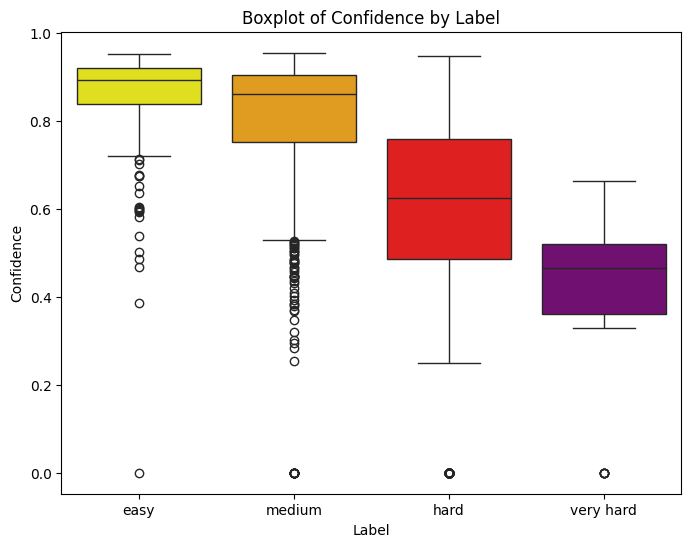

In [105]:
plot_grouped_boxplot(df_out, 'Confidence')

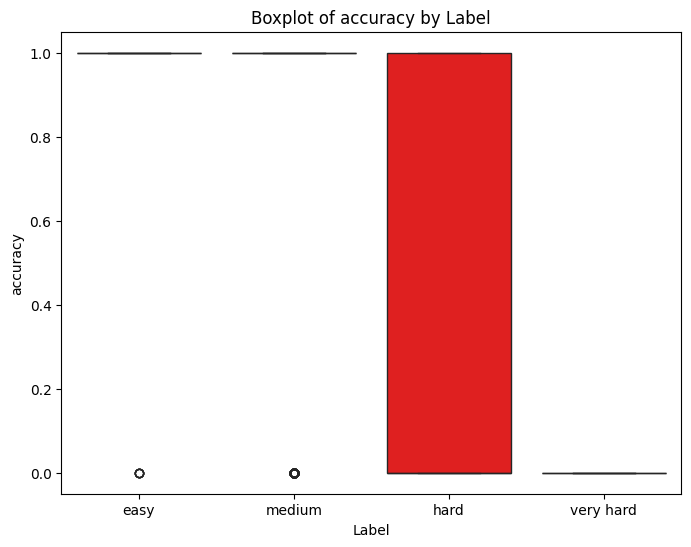

In [106]:
plot_grouped_boxplot(df_out, 'accuracy')

In [107]:
def group_df_and_agg_metrics(df):
    label_grouped = df.groupby('label').agg(
        {
            'mae': 'mean',
            'mse': 'mean',
            'accuracy': 'mean',
            'precision': 'mean'
        }
    )

    label_grouped['rmse'] = np.sqrt(label_grouped['mse'])
    return label_grouped

### Replicate for all other dataframes

--------------------
      All      
--------------------


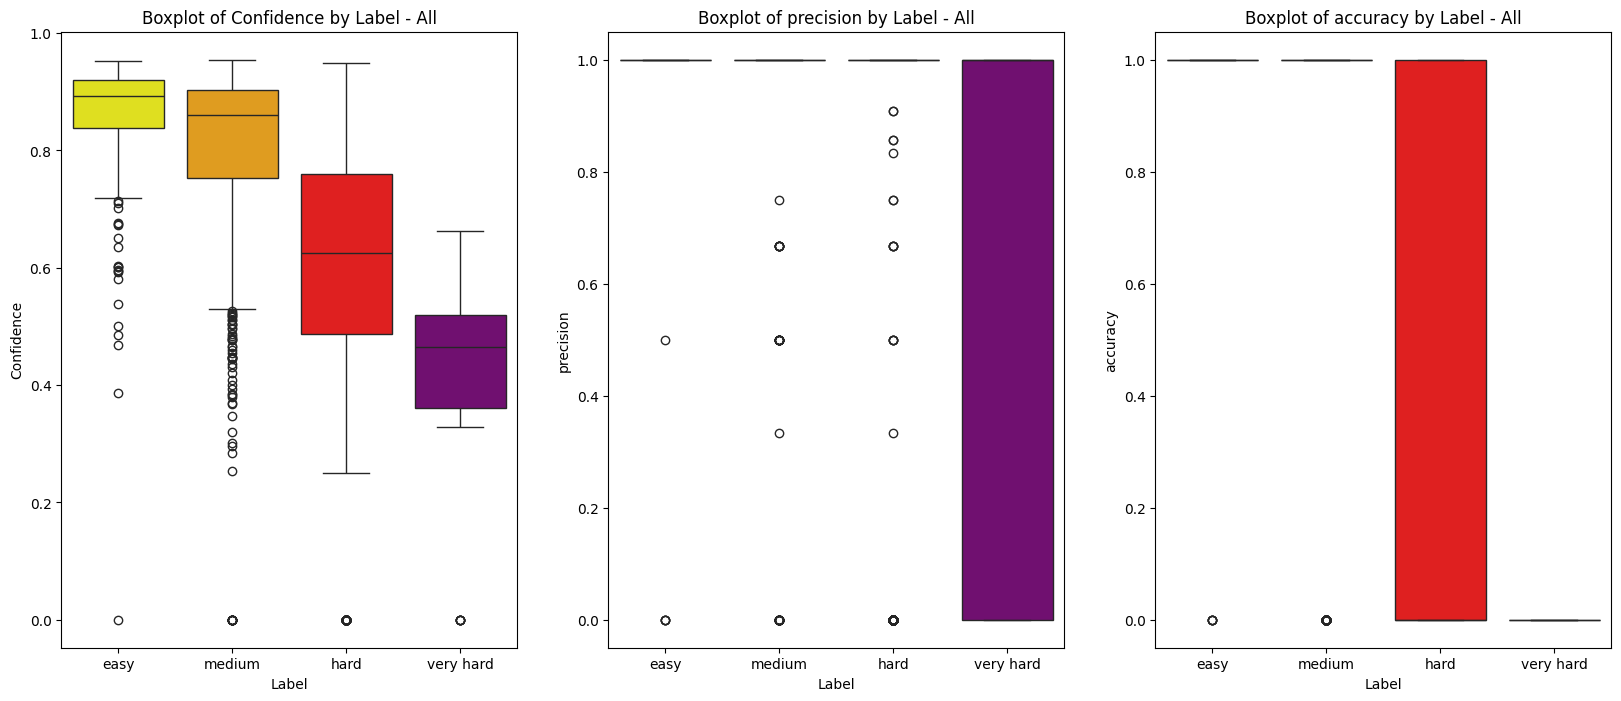

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.033113   0.033113  0.966887   0.970199  0.181969
hard       2.103483  10.210945  0.279602   0.833697  3.195457
medium     0.167079   0.231436  0.857673   0.947710  0.481078
very hard  5.567568  39.729730  0.000000   0.648649  6.303152


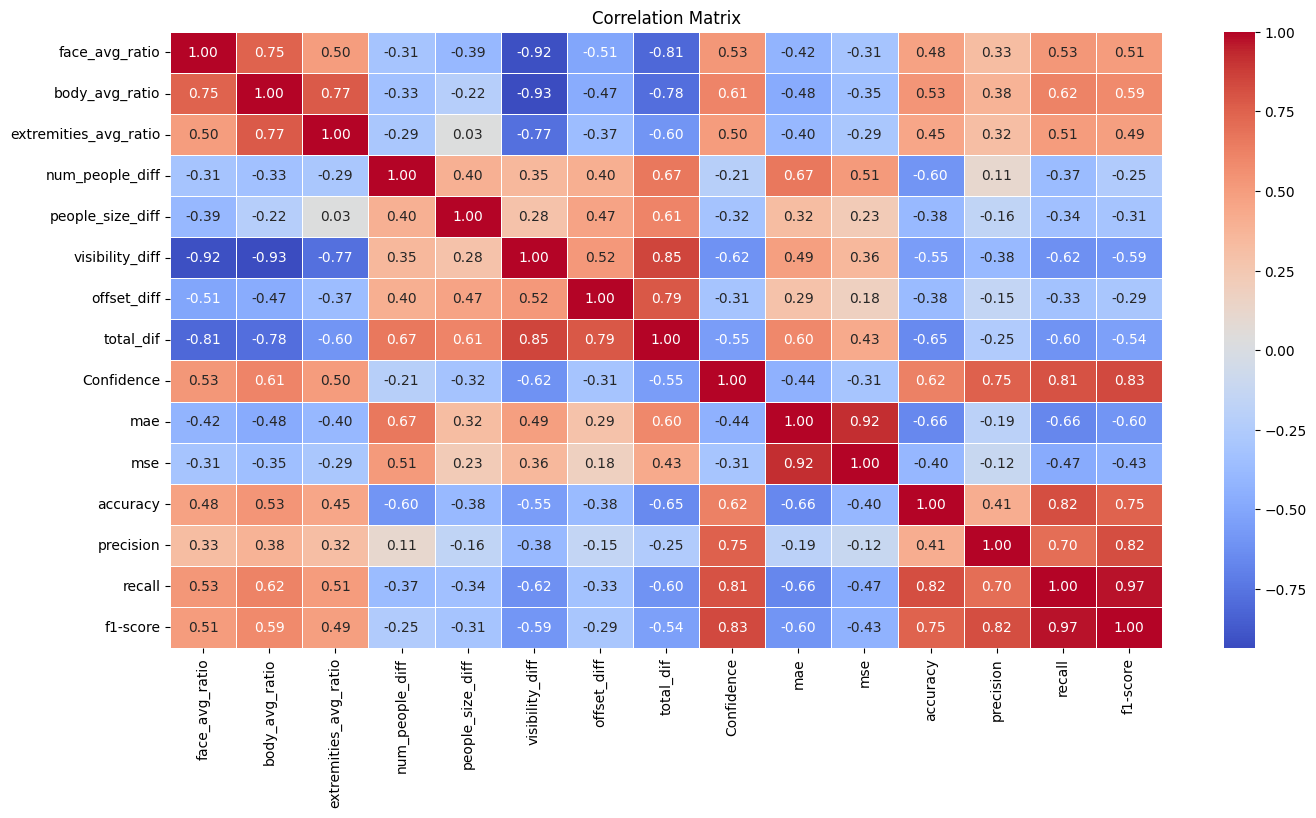

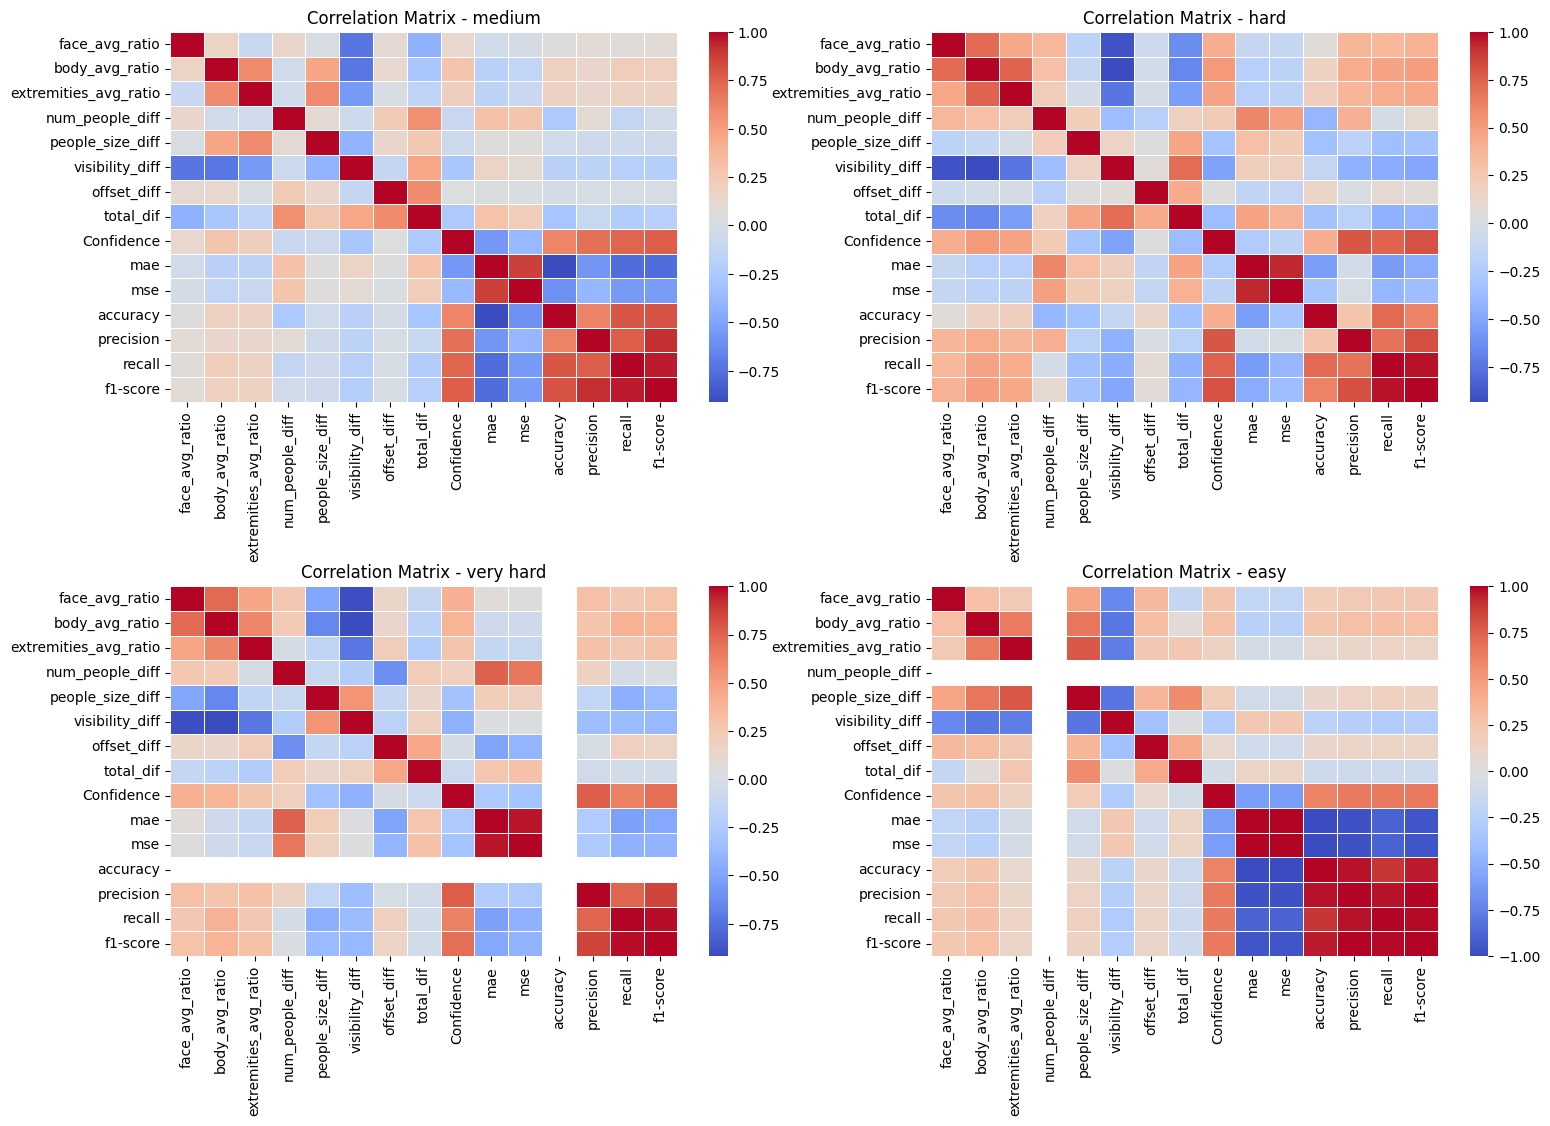

--------------------
      Top25      
--------------------


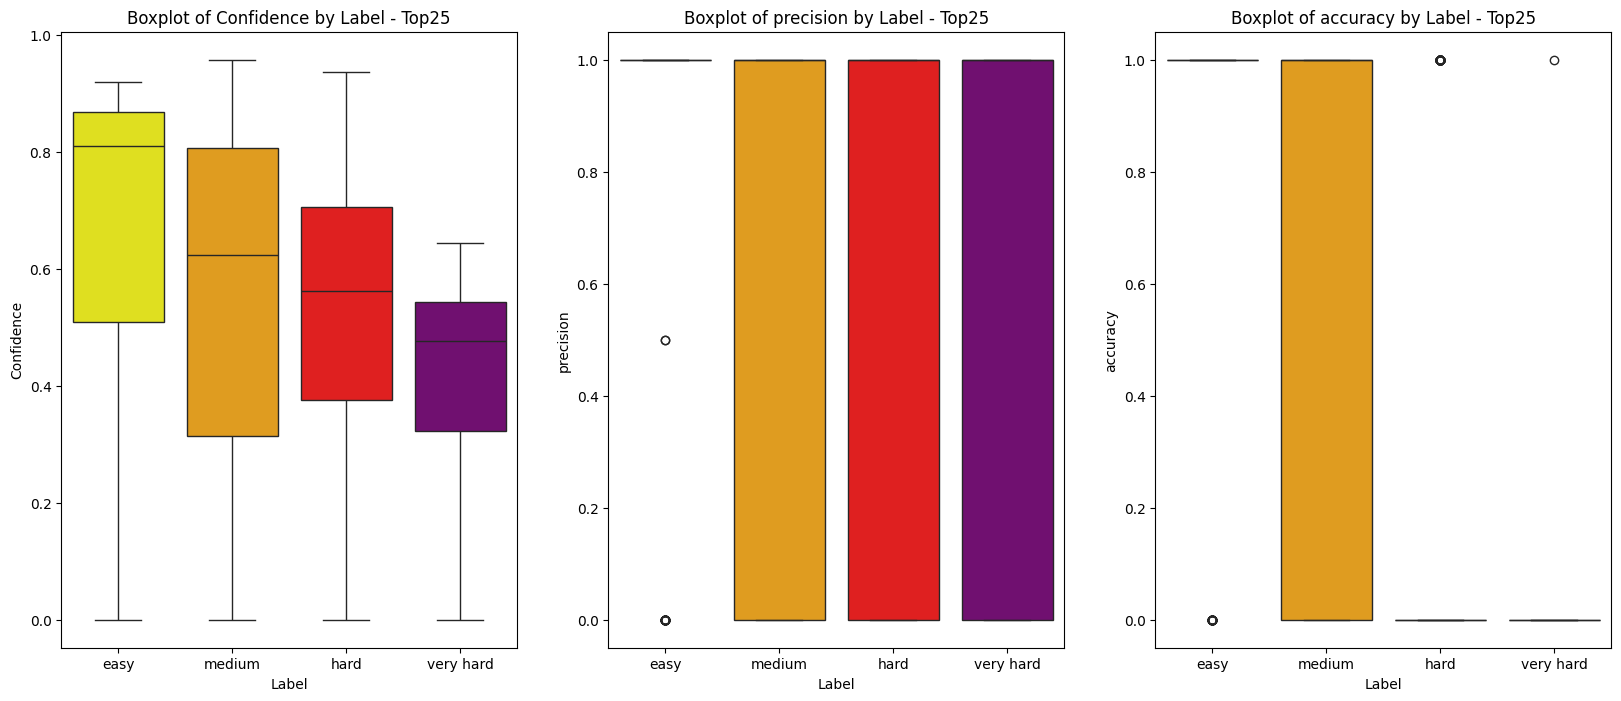

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.243902   0.243902  0.756098   0.762195  0.493865
hard       1.905013   8.079156  0.242744   0.697142  2.842386
medium     0.587276   0.890701  0.518760   0.653290  0.943770
very hard  4.823529  34.470588  0.058824   0.647059  5.871166


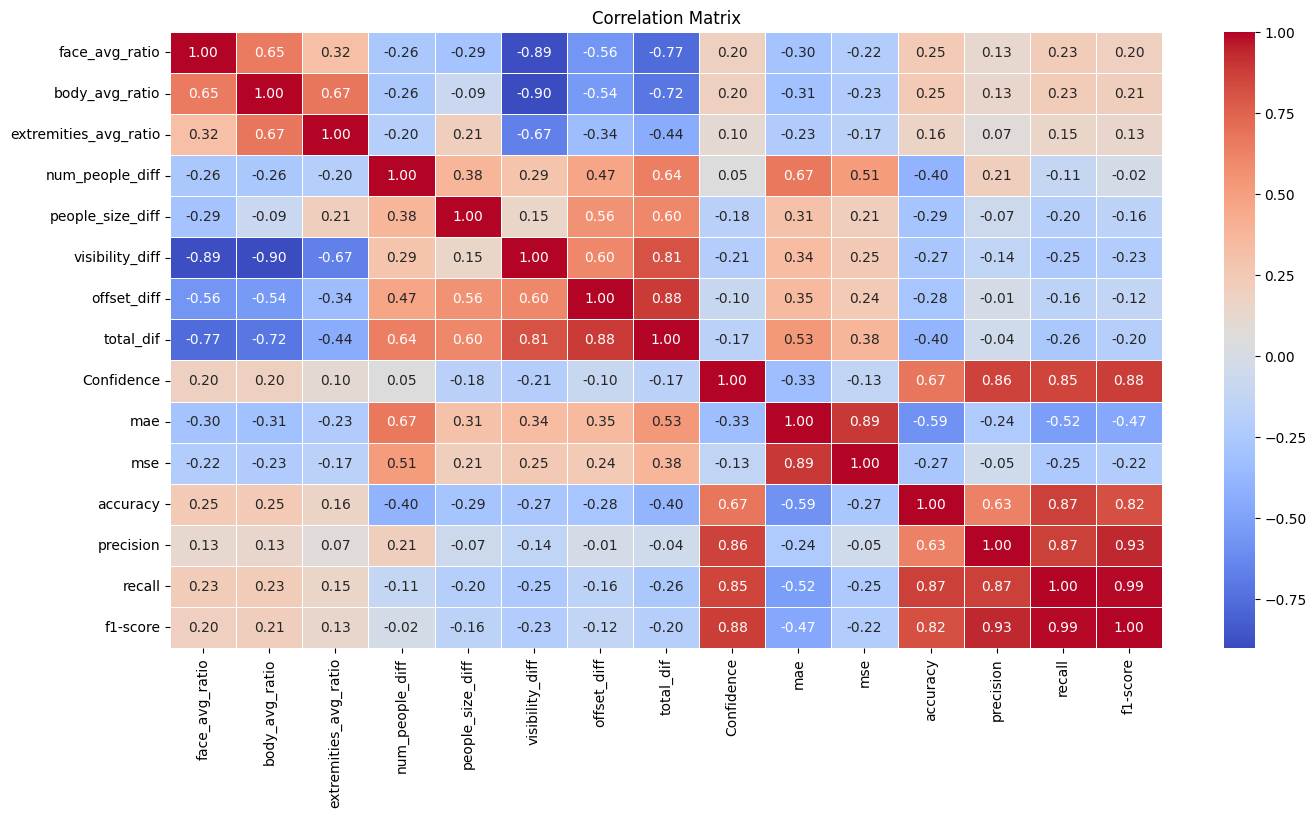

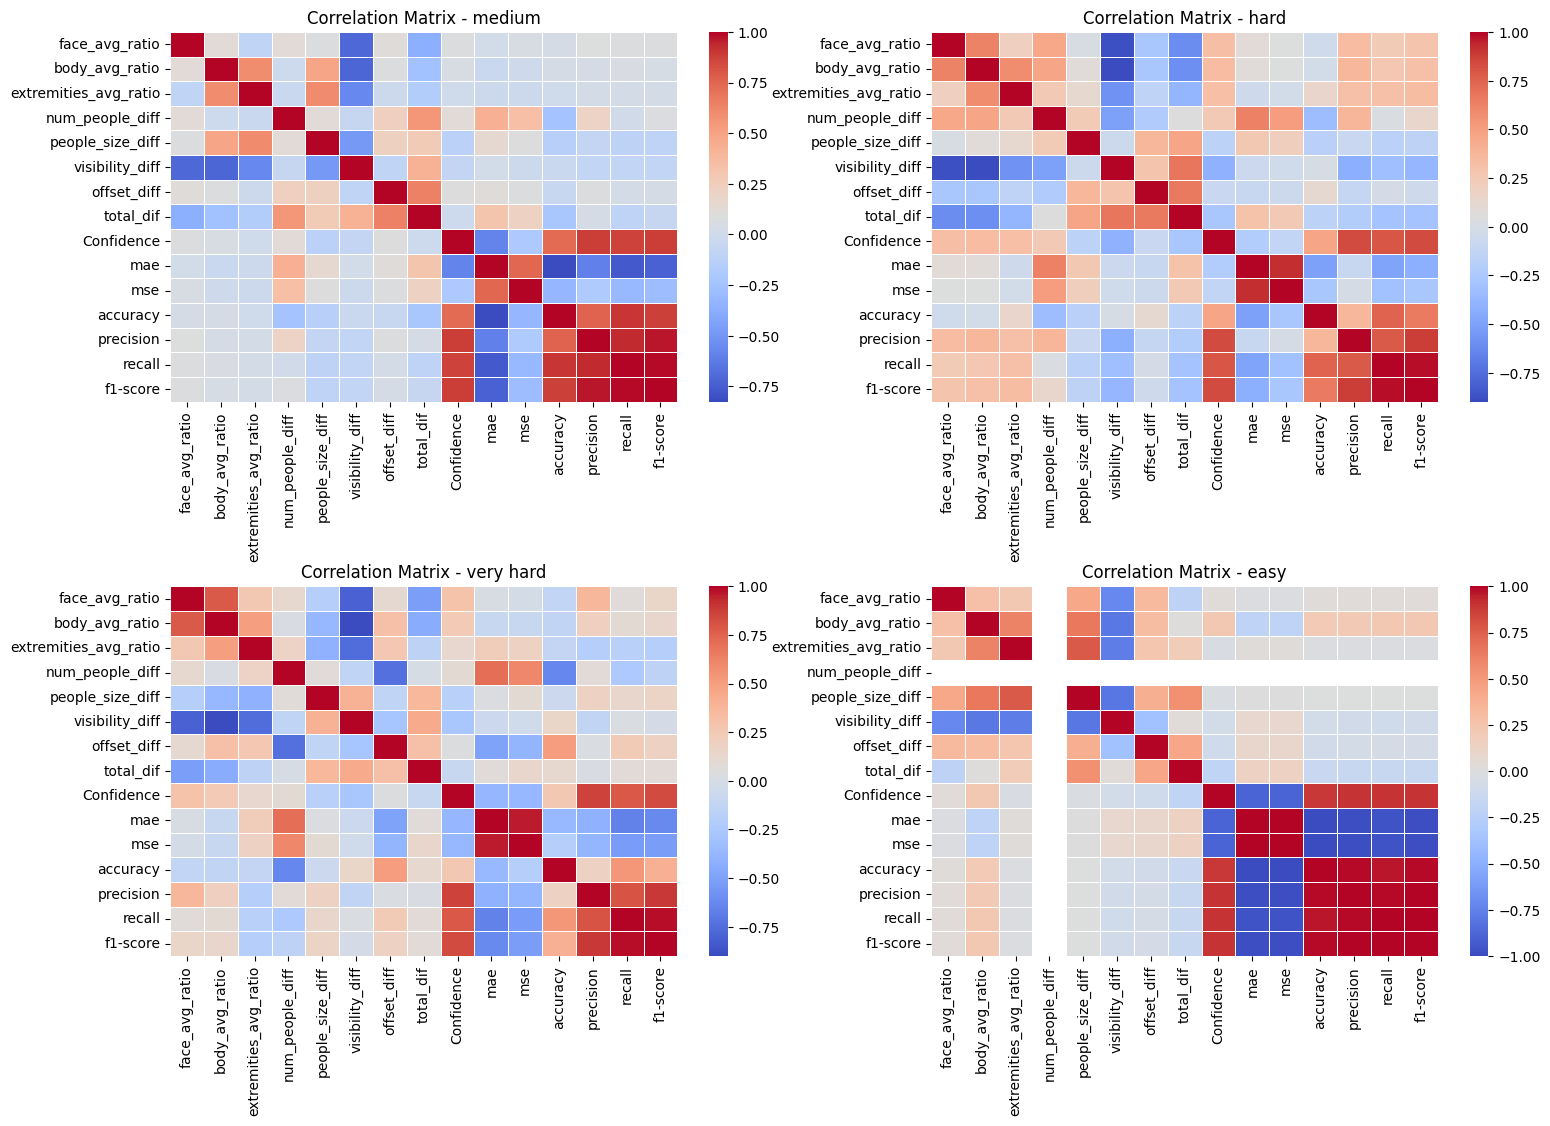

--------------------
      Top50      
--------------------


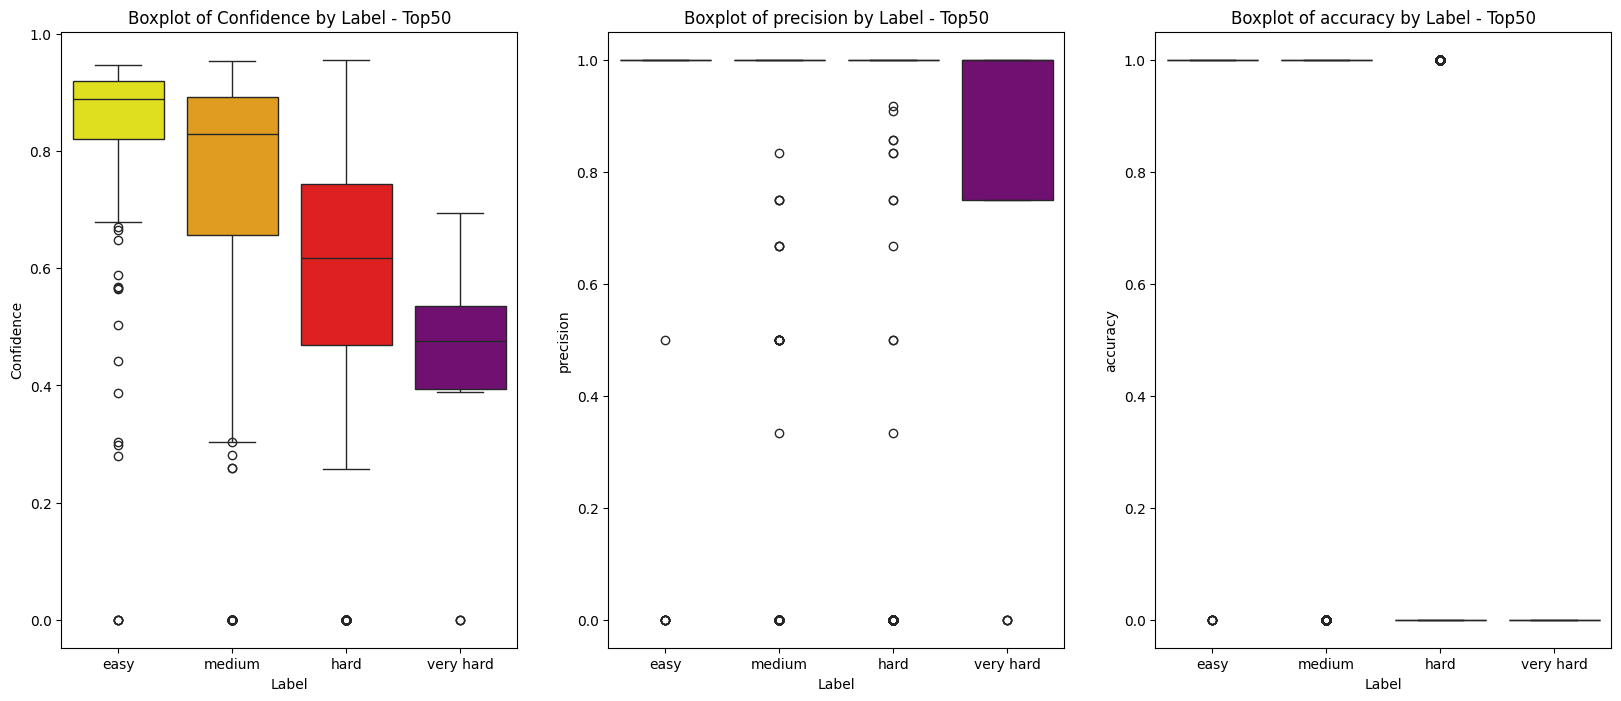

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.057325   0.057325  0.942675   0.945860  0.239426
hard       2.089572   9.311497  0.231283   0.787041  3.051475
medium     0.266344   0.401937  0.776029   0.882466  0.633985
very hard  5.500000  38.625000  0.000000   0.750000  6.214901


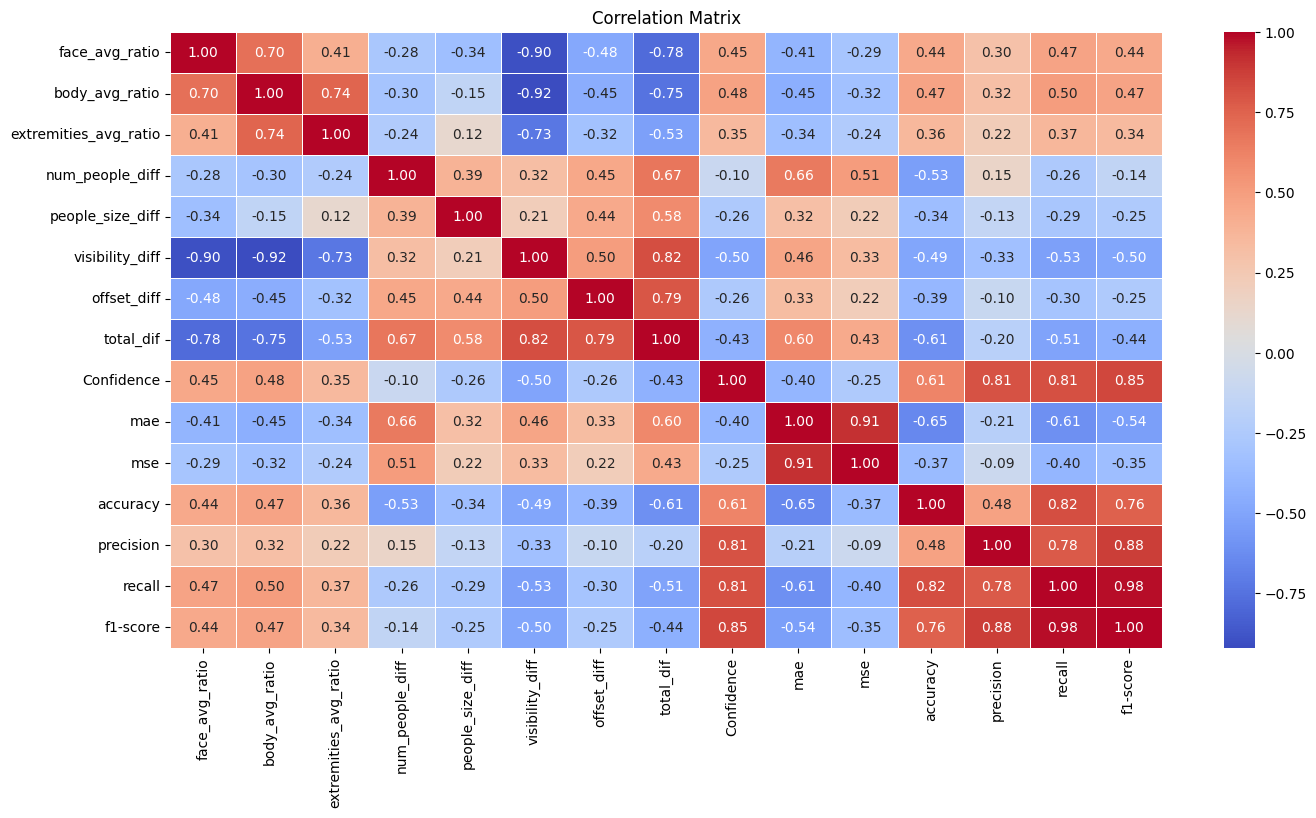

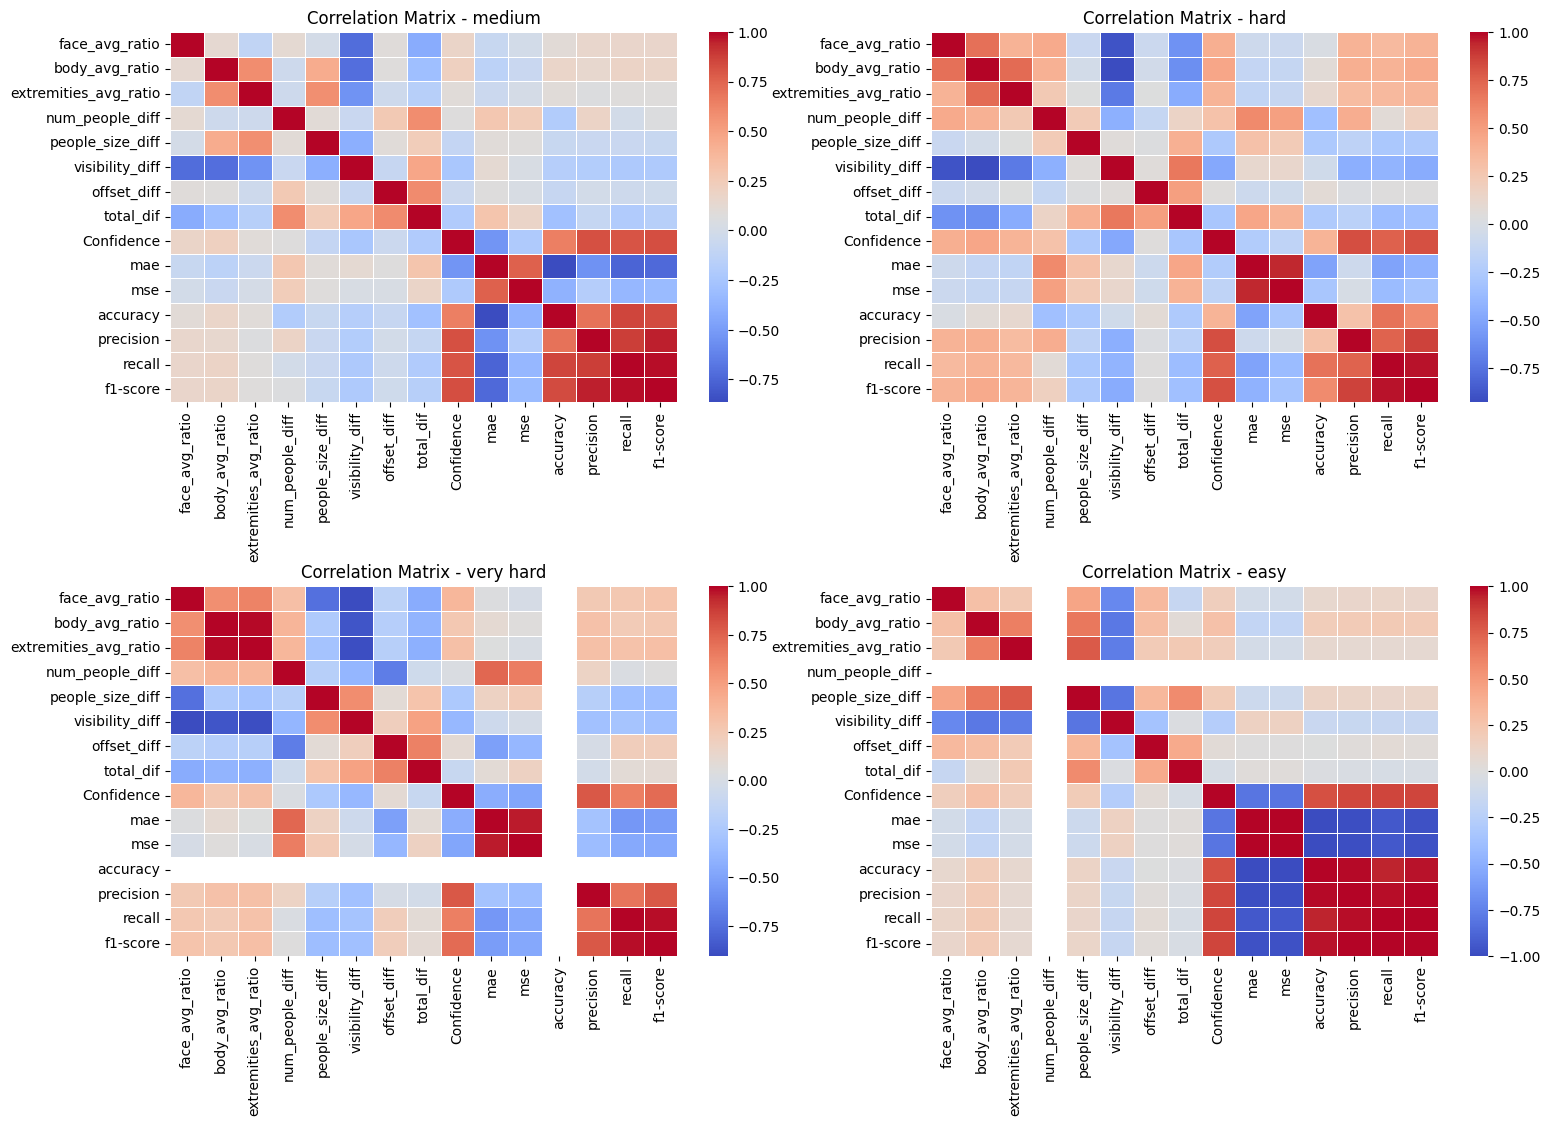

--------------------
      Top75      
--------------------


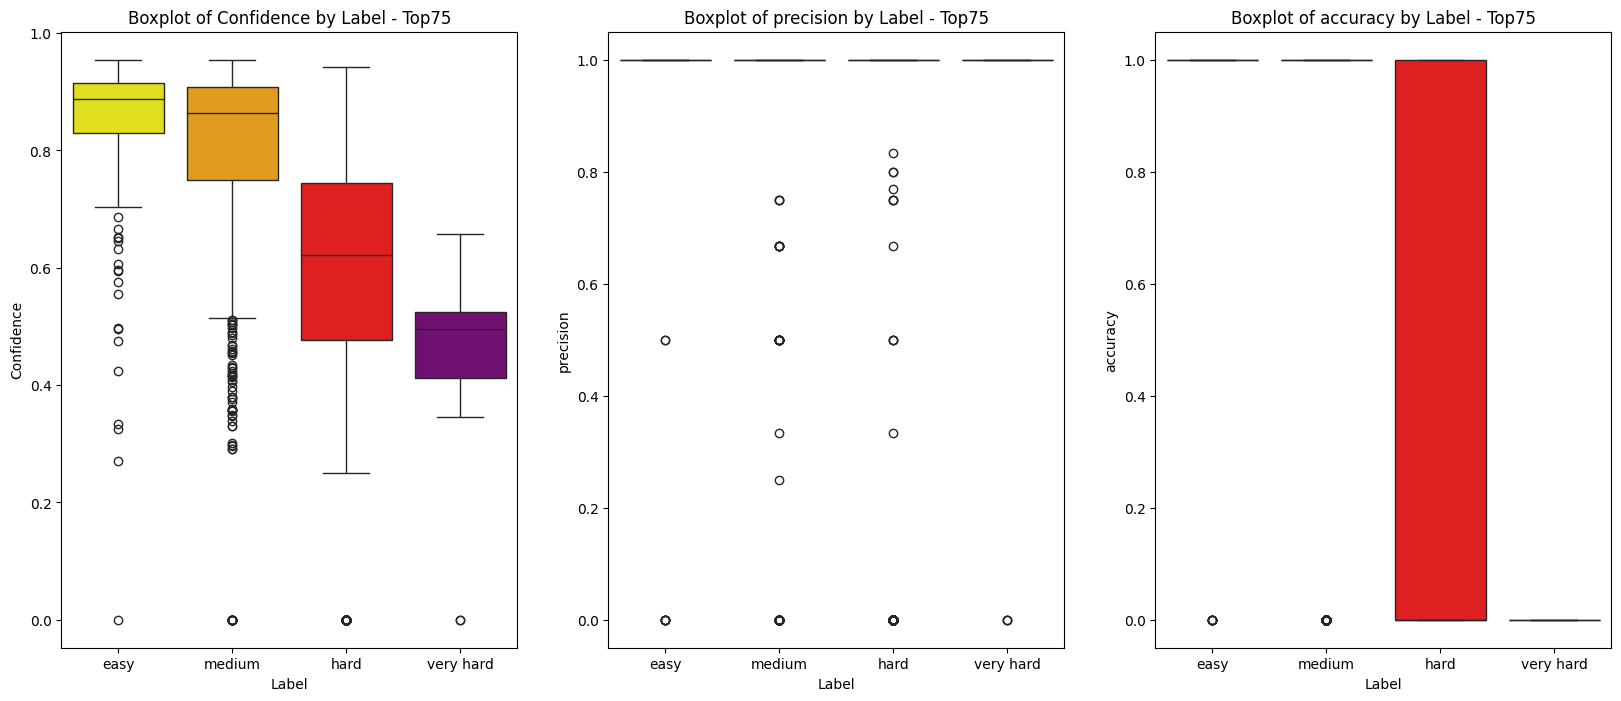

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.052632   0.052632  0.947368   0.953947  0.229416
hard       2.105858  10.017472  0.263104   0.824206  3.165039
medium     0.192831   0.264524  0.835600   0.920066  0.514319
very hard  5.380952  39.571429  0.000000   0.857143  6.290583


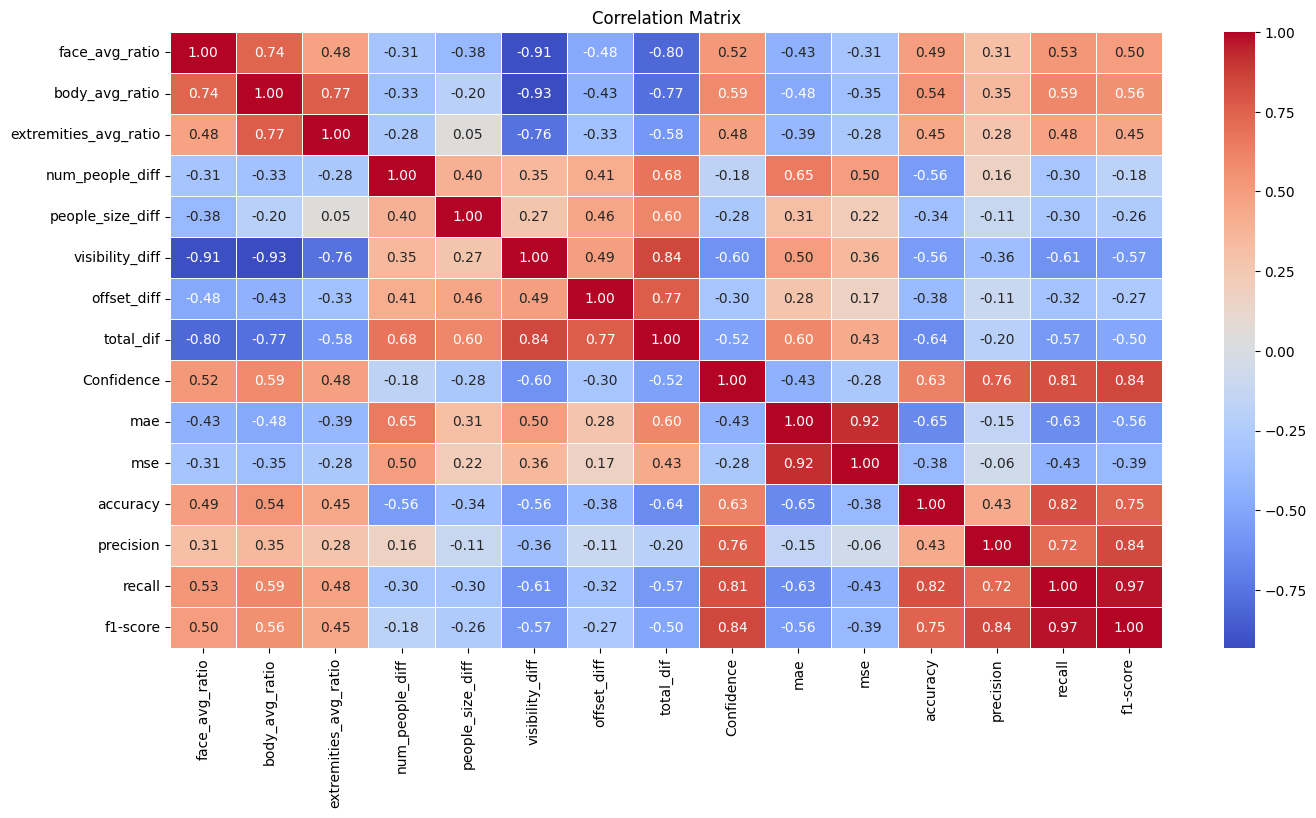

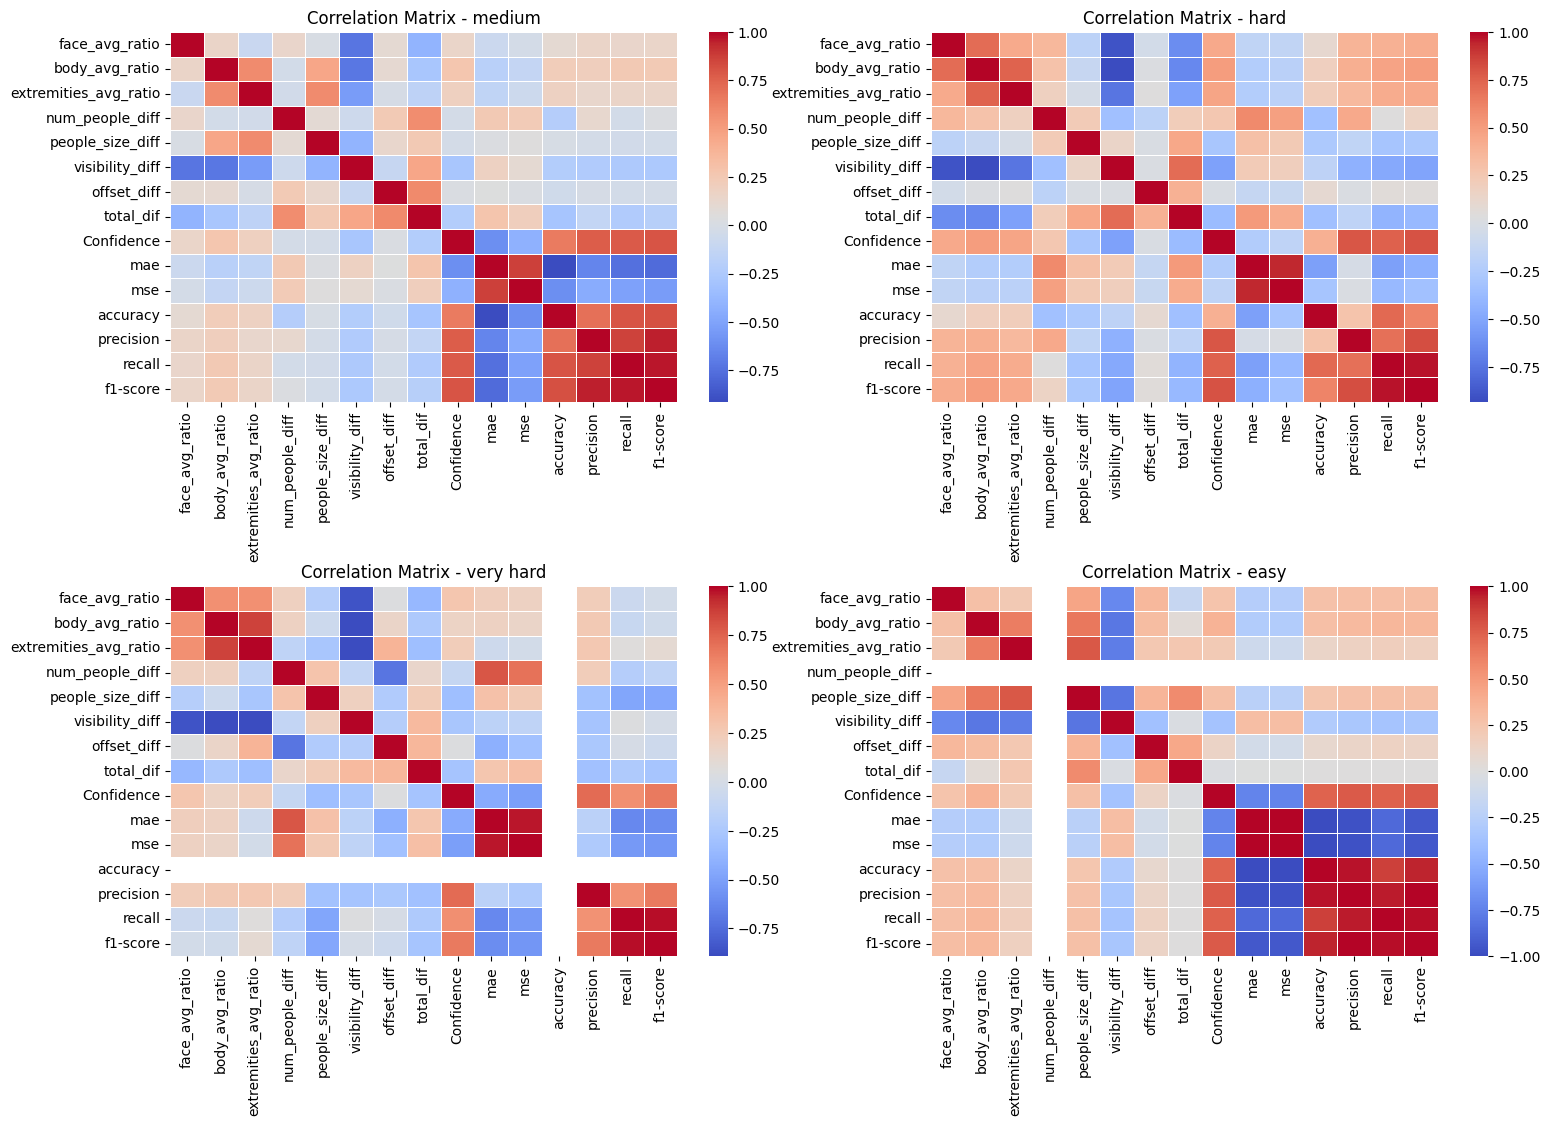

--------------------
      Side25      
--------------------


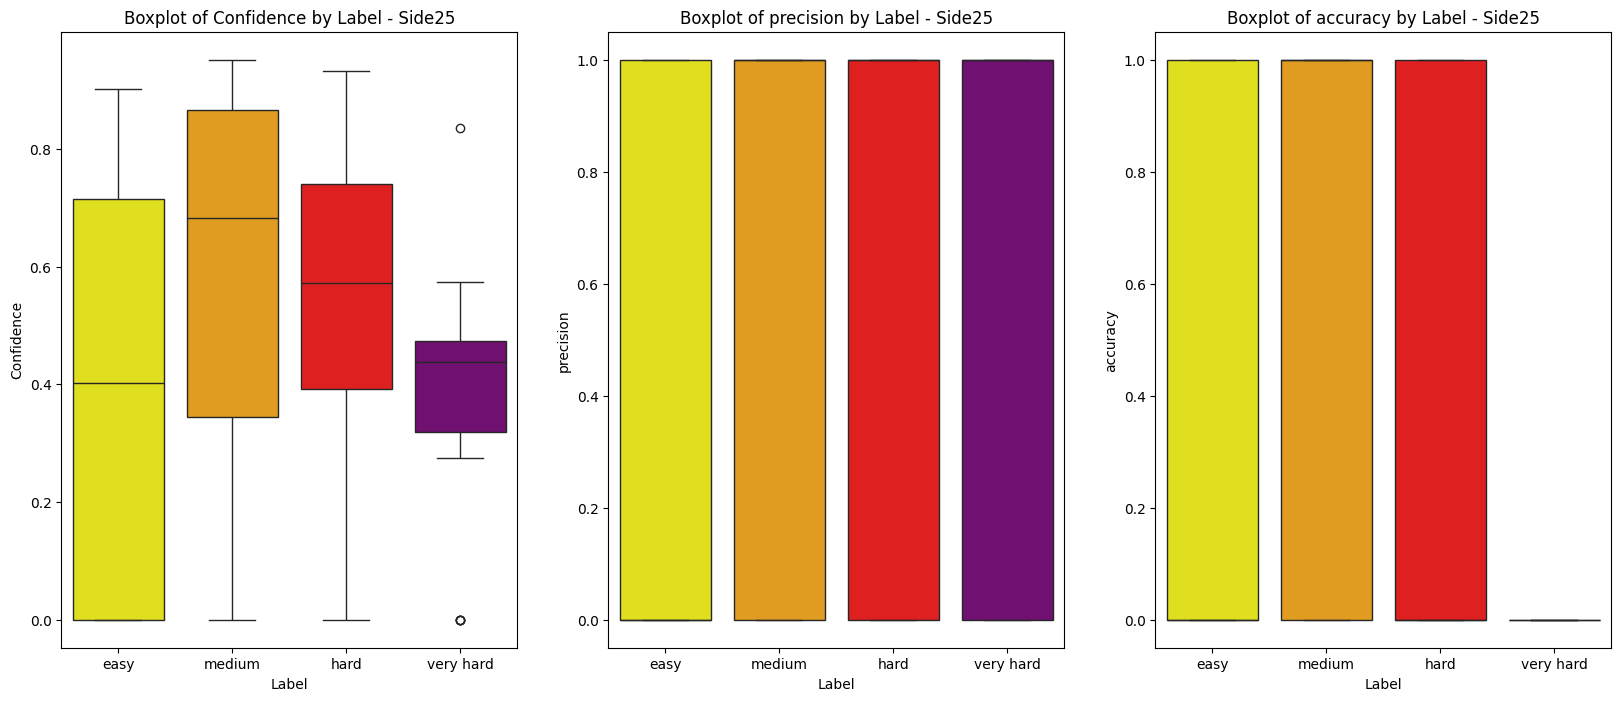

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.576271   0.576271  0.423729   0.423729  0.759125
hard       1.146568   2.730983  0.324675   0.701299  1.652569
medium     0.460377   0.535849  0.575472   0.676415  0.732017
very hard  3.130435  11.739130  0.000000   0.565217  3.426241


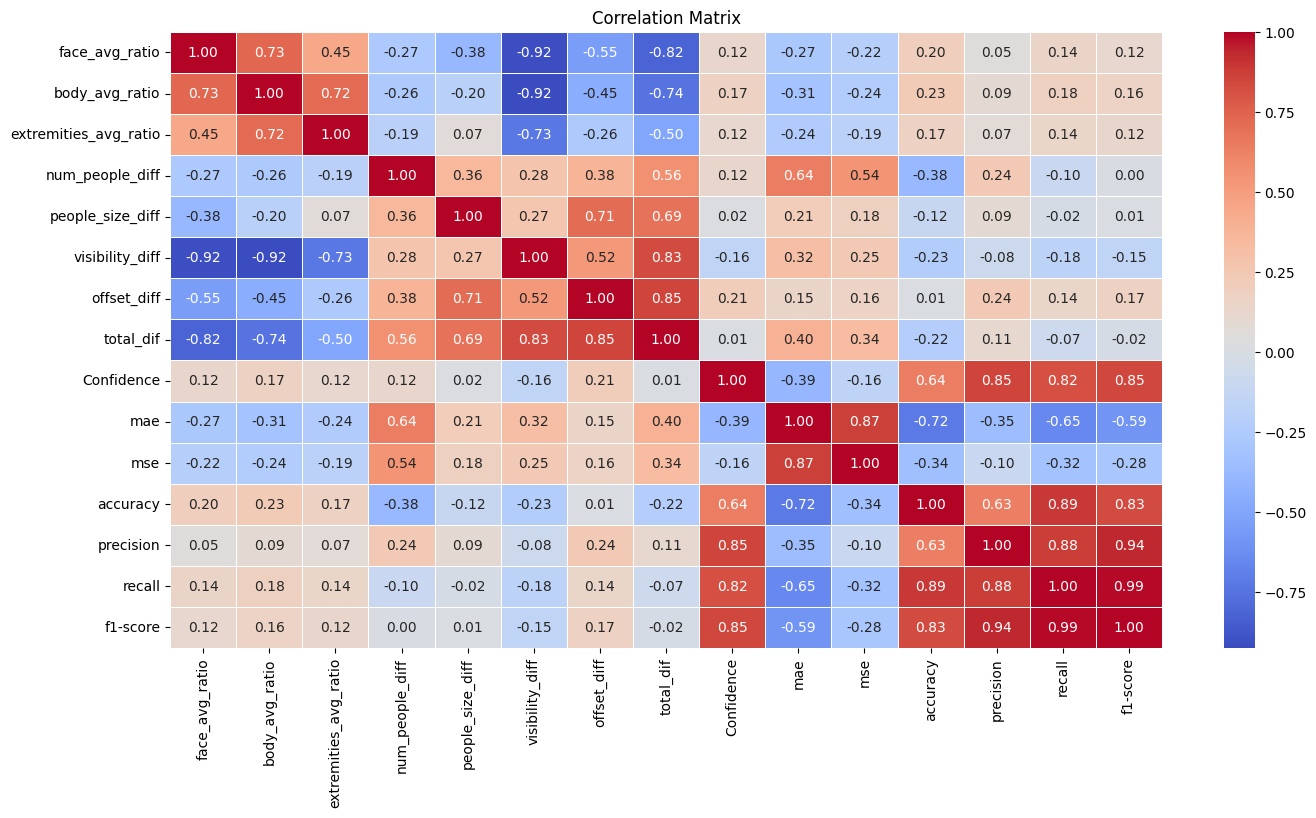

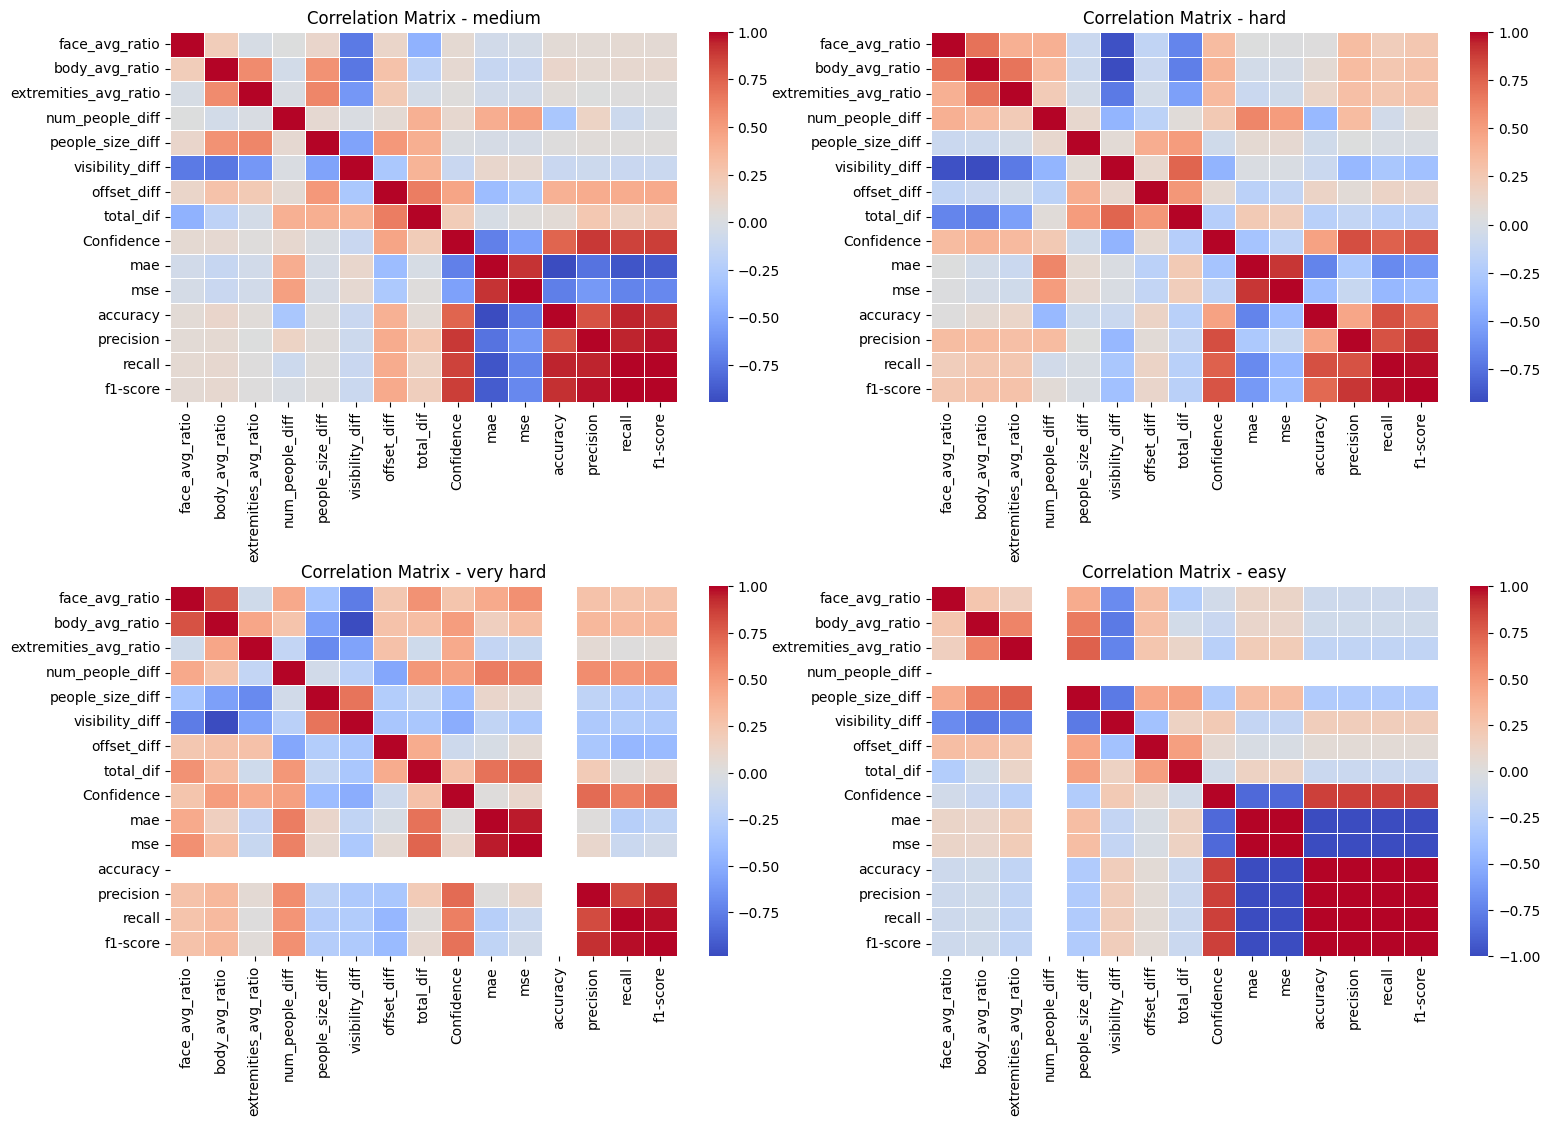

--------------------
      Side50      
--------------------


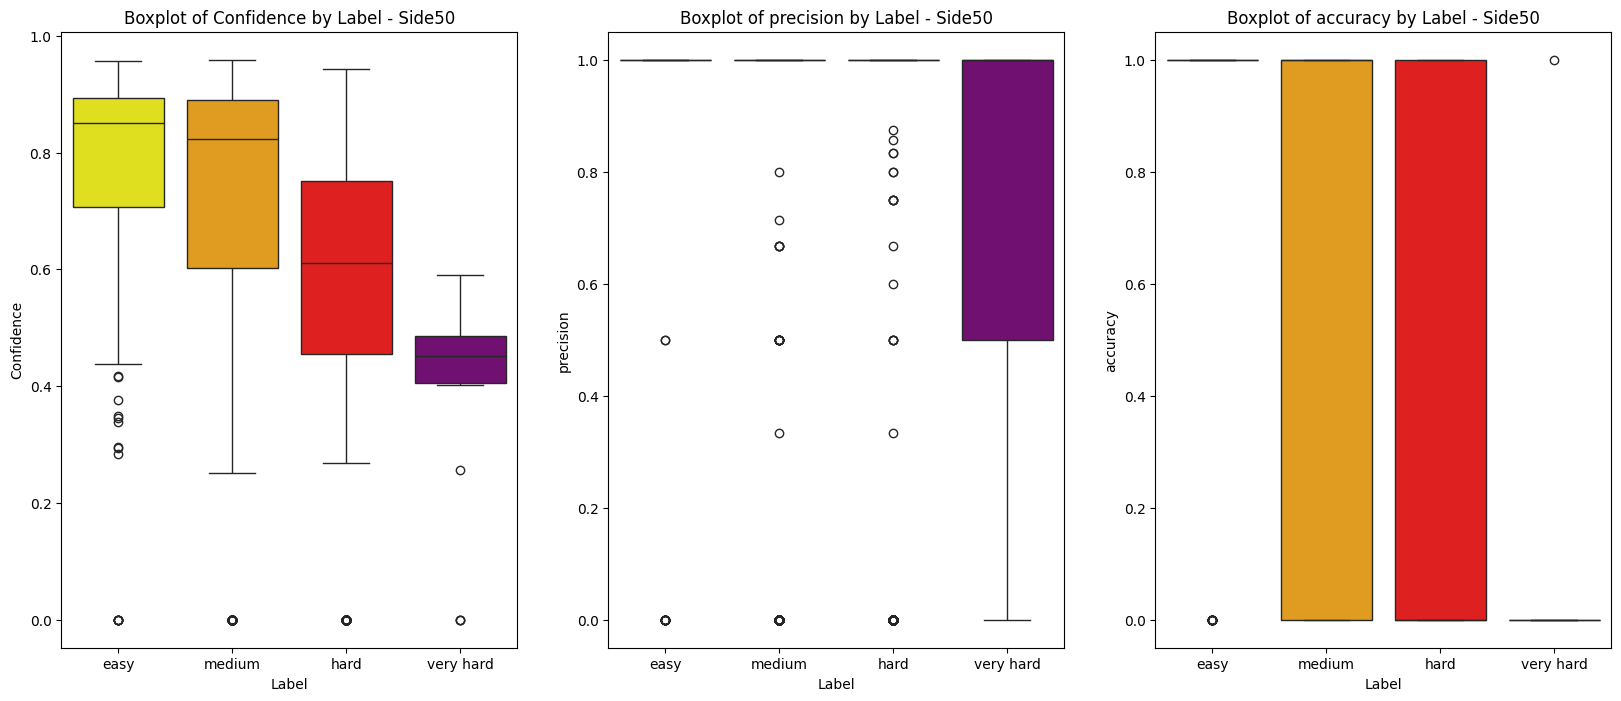

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.139394   0.139394  0.860606   0.866667  0.373355
hard       1.575246   5.206751  0.268636   0.775807  2.281831
medium     0.404789   0.532497  0.645382   0.831829  0.729724
very hard  3.684211  16.526316  0.052632   0.736842  4.065257


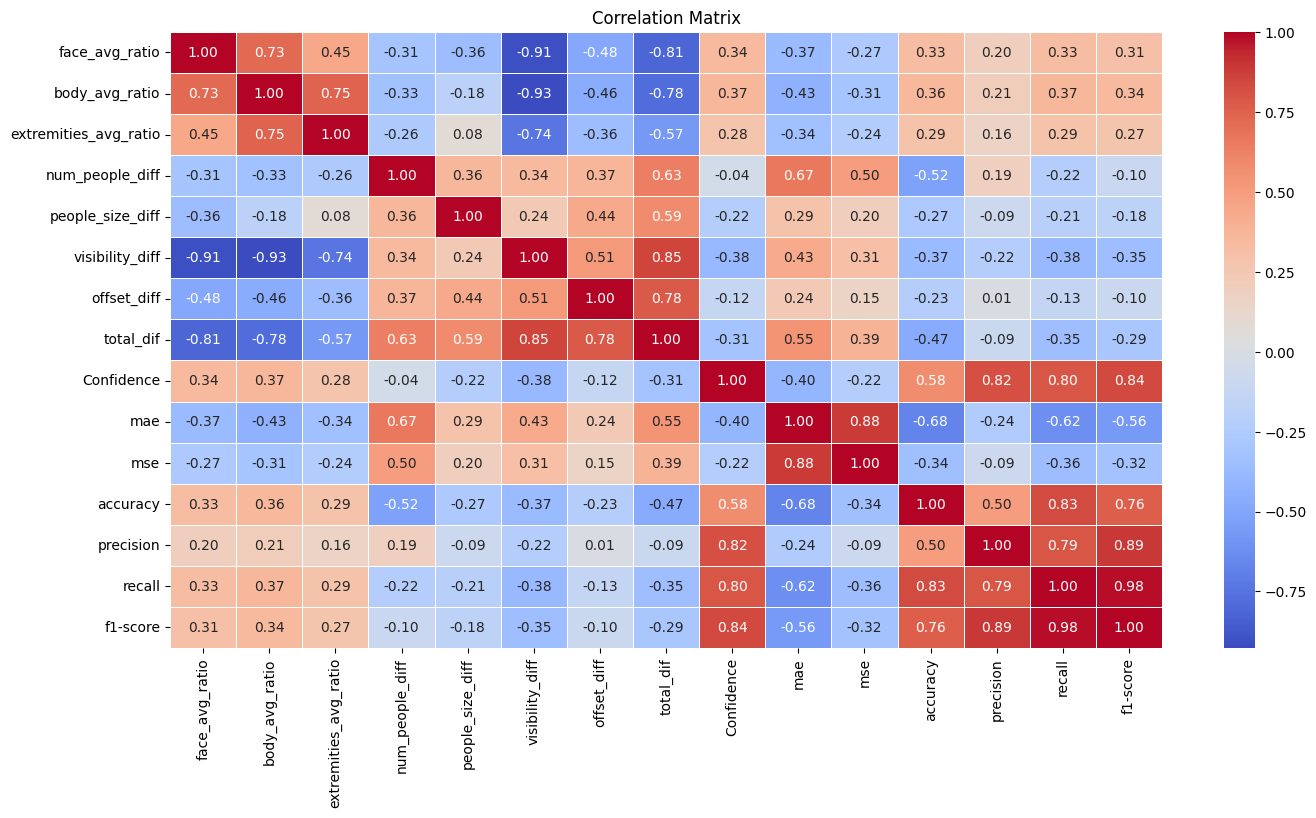

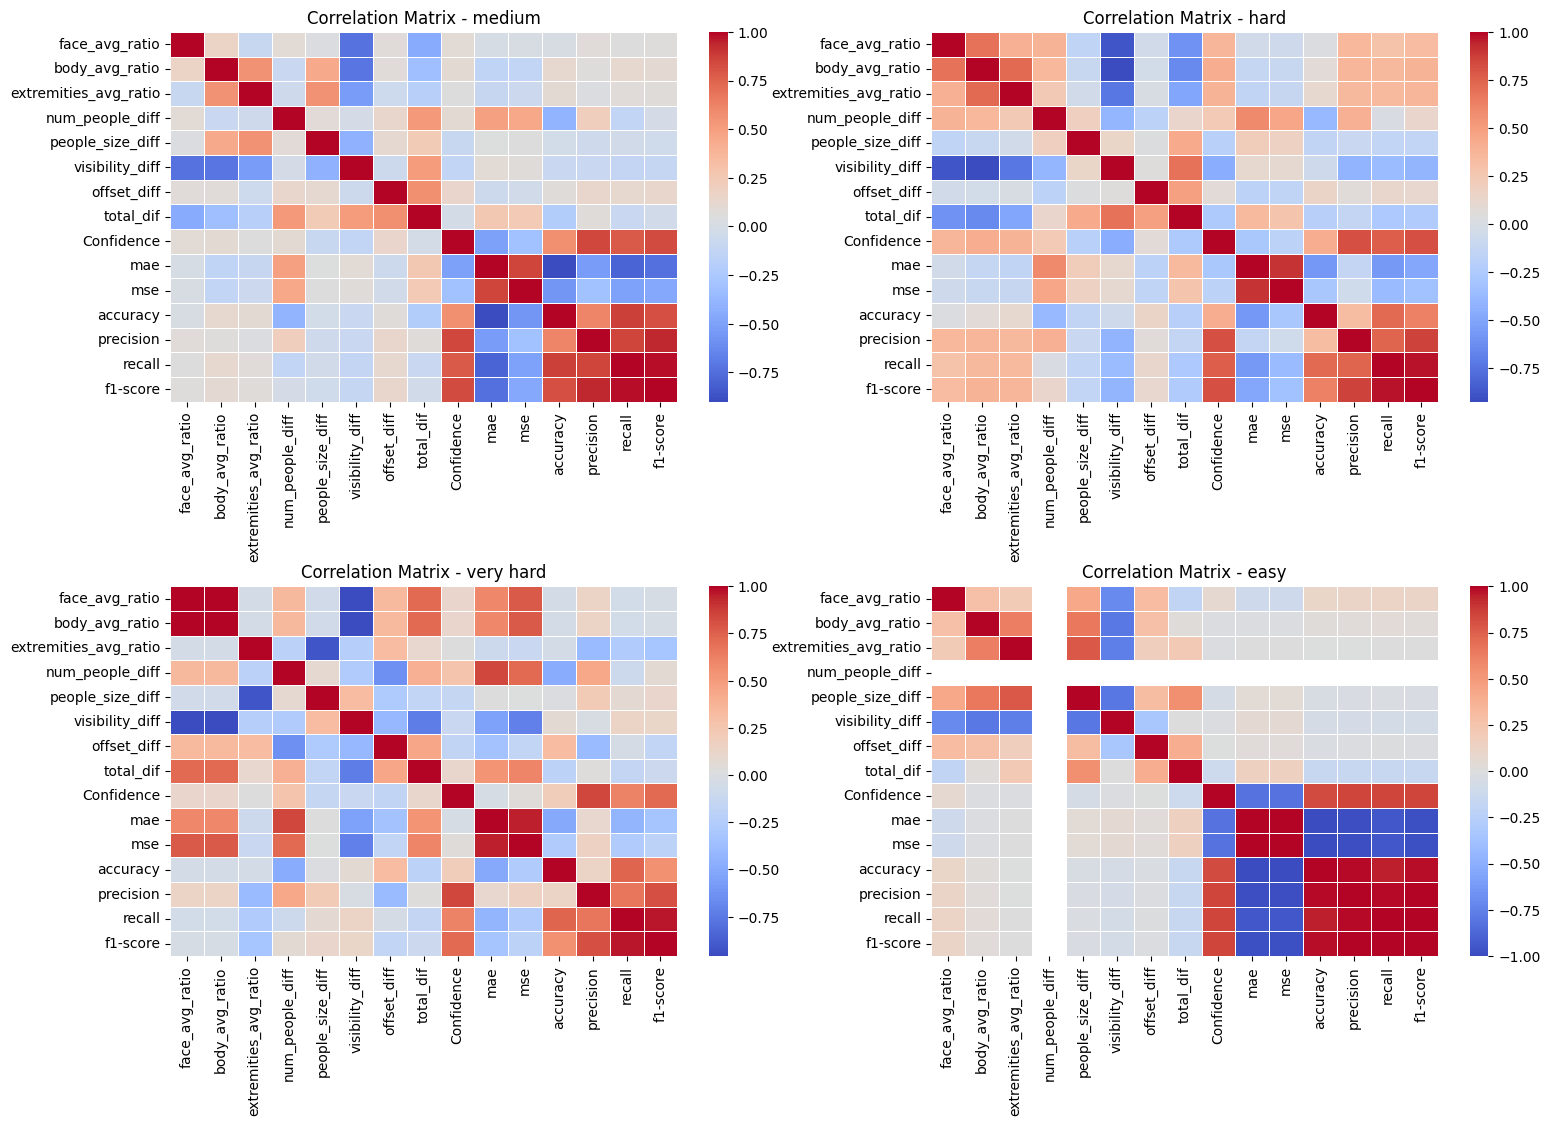

--------------------
      Side75      
--------------------


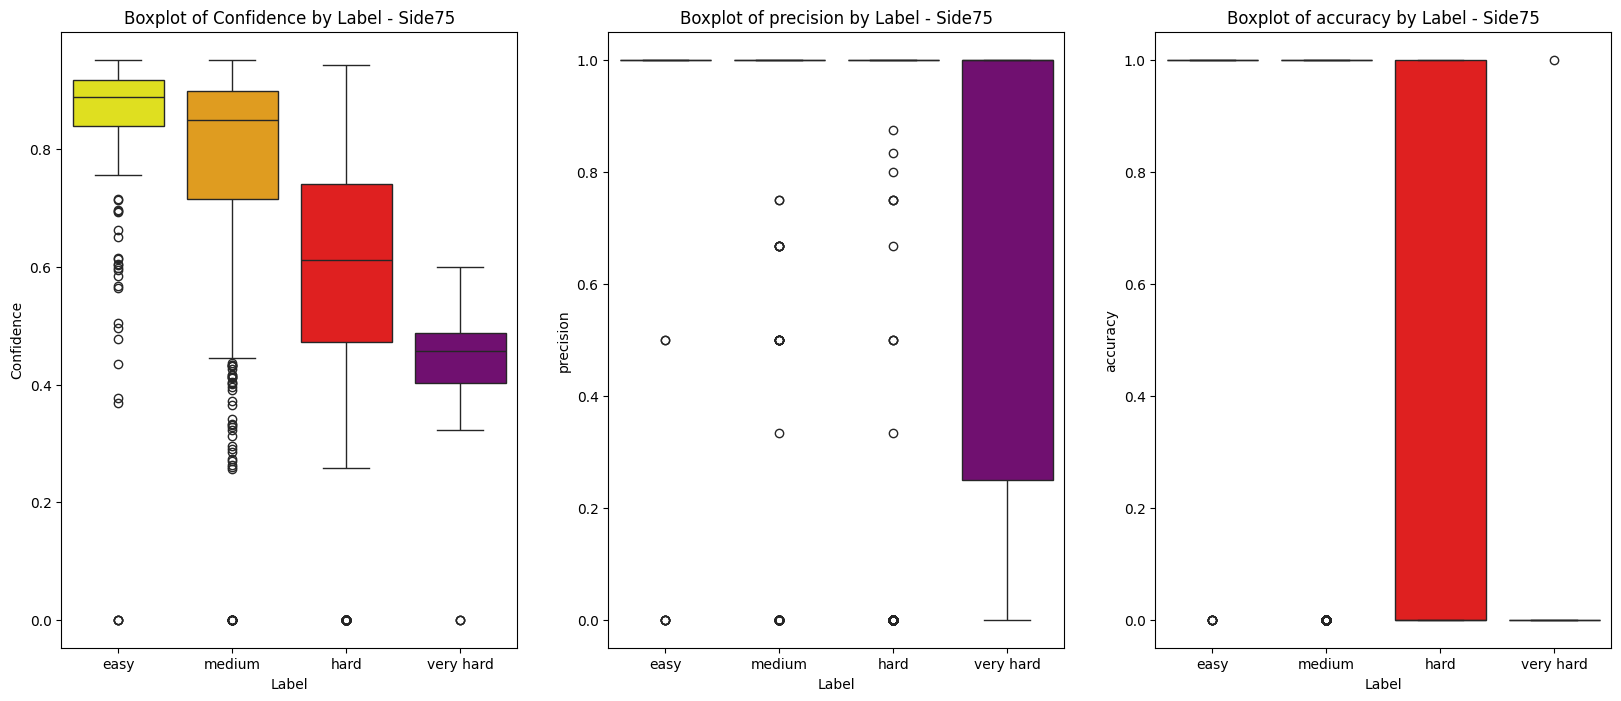

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.051948   0.051948  0.948052   0.954545  0.227921
hard       1.861364   7.500000  0.255682   0.791203  2.738613
medium     0.236872   0.315084  0.798883   0.931099  0.561323
very hard  4.818182  29.181818  0.045455   0.727273  5.402020


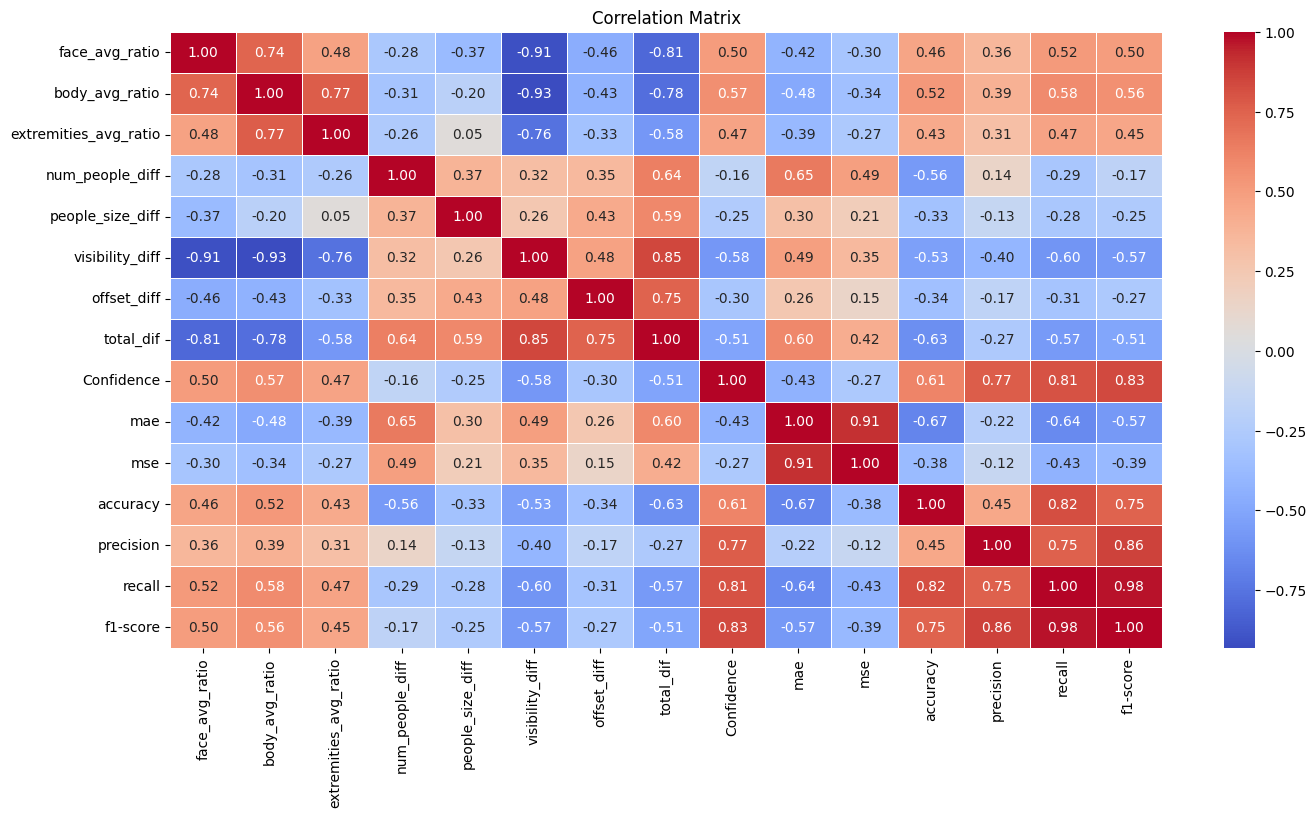

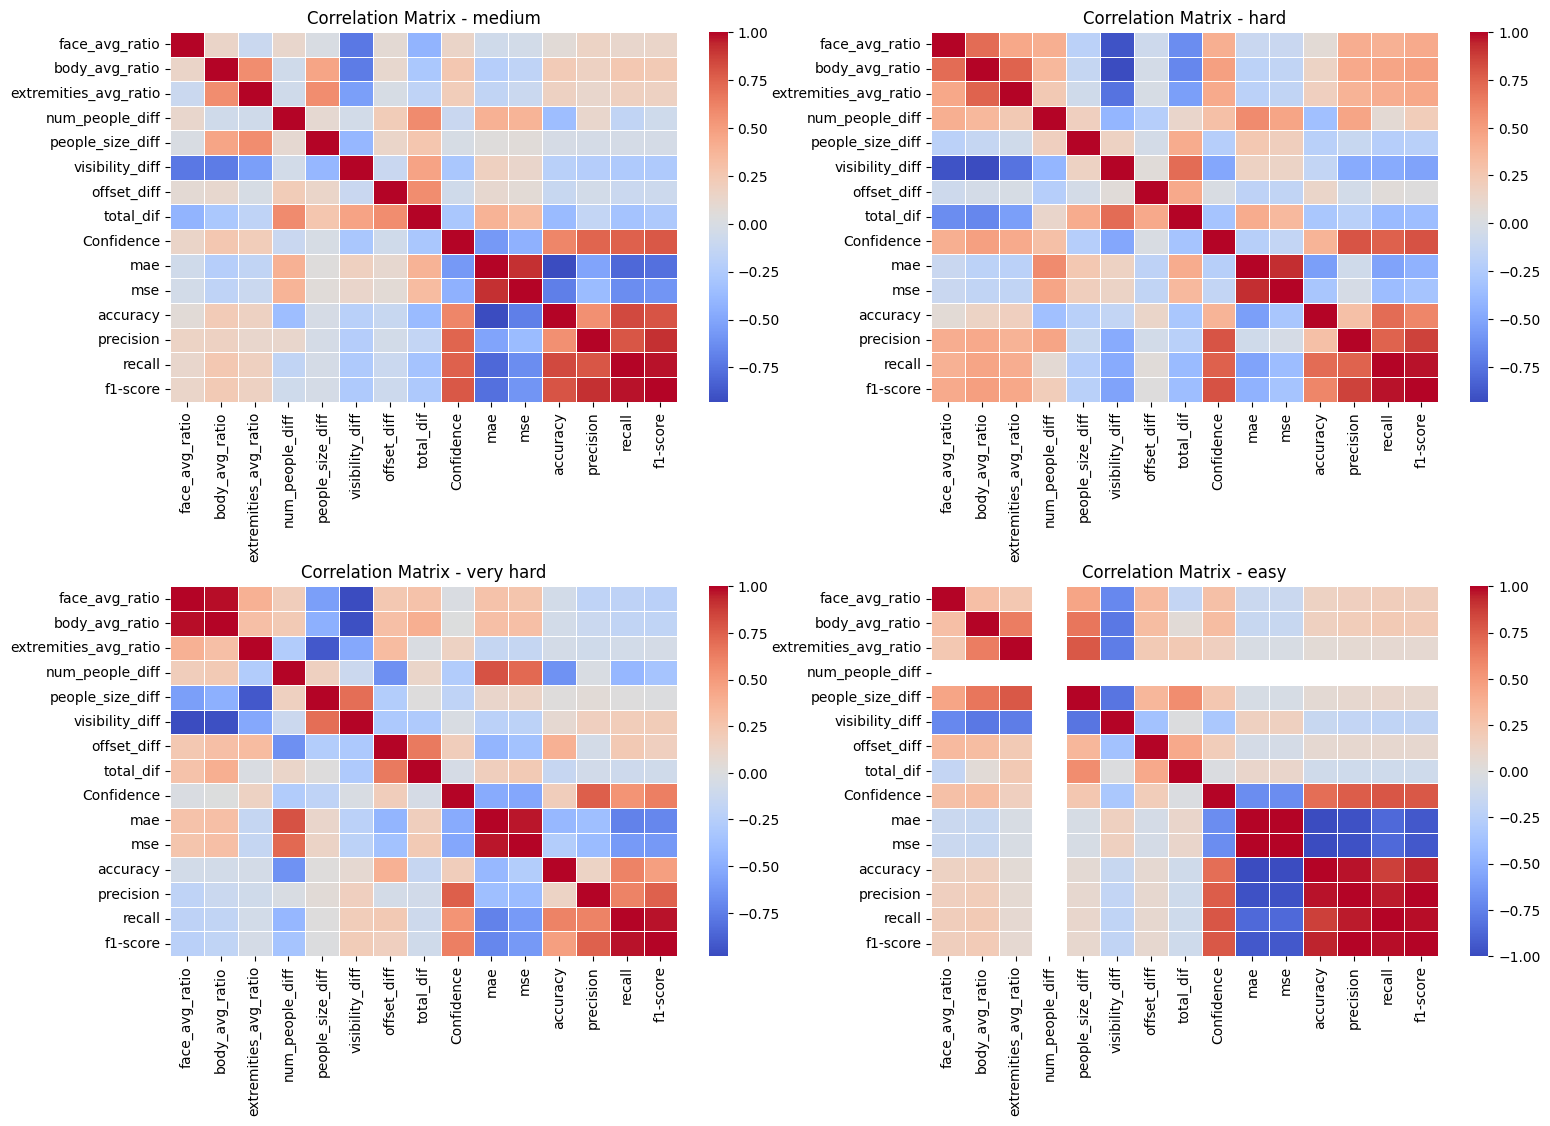

In [110]:
df_list = []
for name in df_names:
    pred_df = pd.read_csv(f'./data/yolo_prediction/{name}.csv')
    anns_df = pd.read_csv(f'./data/coco_diff/{name}.csv')
    anns_df = apply_total_dif_labeling(anns_df, 'total_dif')
    detect_on_threshold(pred_df, 0.5)
    group_pred_df = group_predictions(pred_df)
    df = pd.merge(anns_df, group_pred_df, how='inner', left_on='Img', right_on='Img_ID')
    df.set_index('Img', inplace=True)
    adding_precision_feature(df)
    adding_metrics_features(df)
    df_list.append(df)
    
    print('-'*20)
    print(' '*5, name, ' '*5)
    print('-'*20)


    plt.figure(figsize=(20,8))
    plt.subplot(1, 3, 1)
    plot_grouped_boxplot(df, 'Confidence', name=name, subplot=True)
    plt.subplot(1, 3, 2)
    plot_grouped_boxplot(df, 'precision', name=name, subplot=True)
    plt.subplot(1, 3, 3)
    plot_grouped_boxplot(df, 'accuracy', name=name, subplot=True)
    plt.show()
    
    print(group_df_and_agg_metrics(df))
    plt.figure(figsize=(16,8))
    correlation_matrix = df.drop(['label', 'num_people', 'detected', 'false_pos', 'false_neg', 'true_pos', 'offset', 'Format'], axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()
    
    correlation_matrices = {}


    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    for index, label in enumerate(df['label'].unique()):
        df_label = df[df['label'] == label]
        correlation_matrix = df_label.drop(['label', 'num_people', 'detected', 'false_pos', 'false_neg', 'true_pos', 'offset', 'Format'], axis=1).corr()        
        
        plt.subplot(2, 2, index+1)
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title(f'Correlation Matrix - {label}')
        
    plt.subplots_adjust(hspace=0.5, wspace=0.2) 
    plt.show()



### PCA

In [111]:
df_pca = df_pca.drop(['detected', 'num_people'], axis=1)

In [112]:
df_pca

,offset,face_avg_ratio,body_avg_ratio,extremities_avg_ratio,num_people_diff,people_size_diff,visibility_diff,offset_diff,total_dif,label,Confidence,Format
Img,,,,,,,,,,,,
326,0.152845,0.800000,1.000000,0.125000,0.500000,0.777912,0.275000,0.152845,0.426439,medium,0.866764,rgb
1149,0.457257,0.566667,0.510417,0.416667,0.923077,0.968225,0.480208,0.457257,0.707192,hard,0.607025,rgb
1200,0.634782,0.000000,0.000000,0.000000,0.750000,0.999022,1.000000,0.634782,0.845951,hard,0.739418,rgb
1319,0.509654,0.600000,0.500000,0.812500,0.500000,0.946072,0.387500,0.509654,0.585807,medium,0.431452,rgb
1900,0.254233,0.000000,0.000000,0.000000,0.500000,0.994862,1.000000,0.254233,0.687274,hard,0.000000,b&w
...,...,...,...,...,...,...,...,...,...,...,...,...
579891,0.345929,0.800000,1.000000,1.000000,0.500000,0.936058,0.100000,0.345929,0.470497,medium,0.909920,rgb
580781,0.205454,0.600000,0.750000,0.250000,0.500000,0.531672,0.425000,0.205454,0.415531,medium,0.841013,rgb
581183,0.517451,0.150000,0.416667,0.354167,0.923077,0.993702,0.729167,0.517451,0.790849,hard,0.605279,rgb


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import cm

def draw_PCA(df):
    # 1. Separa la variabile "Confidence"
    X = df.drop(['Confidence', 'label', 'Format'], axis=1)  # Escludiamo 'label', 'Confidence' e 'Format'
    confidence = df['Confidence']  # Variabile per il colore

    # 2. Eseguiamo One-Hot Encoding sulla colonna "label"
    label_encoder = OneHotEncoder(drop='first', dtype=int)  # Rimuoviamo la prima categoria per evitare la collinearità
    labels_encoded = label_encoder.fit_transform(df[['label']]).toarray()

    # 3. Eseguiamo One-Hot Encoding sulla colonna "Format"
    format_encoder = OneHotEncoder(drop='first', dtype=int)
    format_encoded = format_encoder.fit_transform(df[['Format']]).toarray()

    # 4. Aggiungiamo le colonne One-Hot Encoded di "label" e "Format" ai dati
    X_encoded = np.hstack([X.values, labels_encoded, format_encoded])  # Uniamo i dati numerici e le colonne One-Hot Encoded

    # 5. Standardizzazione dei dati
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # 6. Eseguiamo la PCA
    pca = PCA(n_components=2)  # Riduzione a 2 componenti principali
    X_pca = pca.fit_transform(X_scaled)

    # 7. Definisci i colori per la variabile 'label'
    label_colors = {'easy': 'g', 'medium': 'b', 'hard': 'r', 'very hard': 'y'}

    # 8. Crea il primo grafico: PCA con hexbin e colorato in base a Confidence
    plt.figure(figsize=(8, 6))
    plt.hexbin(X_pca[:, 0], X_pca[:, 1], C=confidence, gridsize=30, cmap='viridis', reduce_C_function=np.mean)
    plt.colorbar(label='Confidence')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA con hexbin, colorato in base a Confidence')

    # 9. Crea il secondo grafico: Vettori di caricamento (loading vectors)
    plt.figure(figsize=(8, 6))
    # Traccia le frecce per ogni variabile
    loading_vectors = pca.components_

    # Aumentiamo la lunghezza delle frecce per renderle più visibili
    arrow_scale = 1.5  # Fattore di scala per le frecce

    # Uniamo i nomi delle variabili originali, dei vettori one-hot e della feature 'Format'
    all_columns = list(X.columns) + list(label_encoder.get_feature_names_out(['label'])) + list(format_encoder.get_feature_names_out(['Format']))

    # Per ogni variabile (compresa quella one-hot encoded), traccia una freccia
    for i, (col_name, vec) in enumerate(zip(all_columns, loading_vectors.T)):
        # Calcoliamo la posizione finale delle freccie
        x_end = vec[0] * arrow_scale
        y_end = vec[1] * arrow_scale
        
        # Rendi le frecce più lunghe con uno zoom maggiore
        plt.arrow(0, 0, x_end, y_end, color='black', alpha=0.7, head_width=0.03, head_length=0.05, linewidth=1.5)
        
        # Spostiamo il testo alla fine della freccia, oltre la posizione finale
        plt.text(x_end * 1.2, y_end * 1.2, col_name, color='black', ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Vettori di Caricamento (Loading Vectors) della PCA')

    # Mostra i grafici
    plt.show()


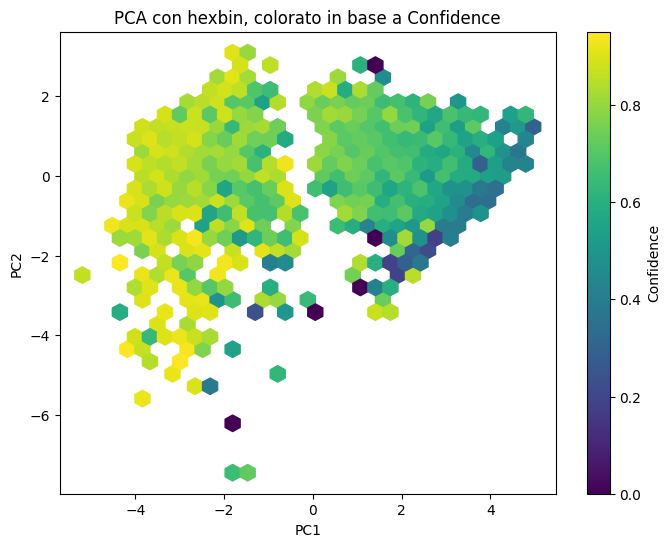

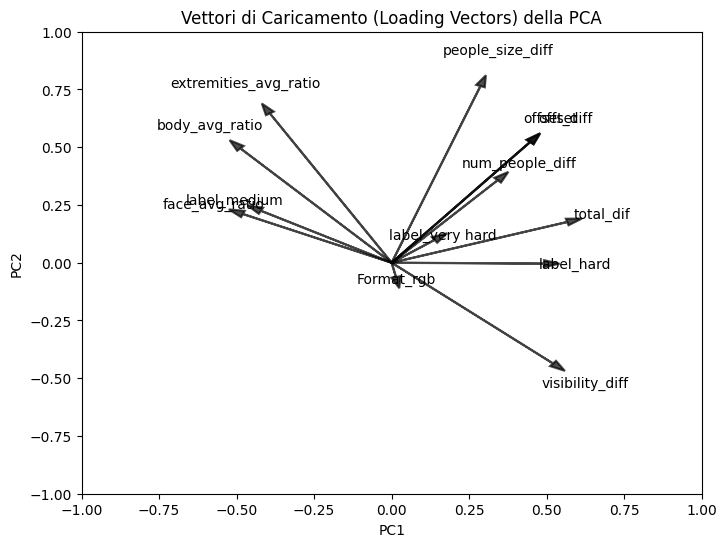

In [127]:
draw_PCA(df_pca)

## Channels analysis

In [128]:
df_list[0]

,num_people,offset,face_avg_ratio,body_avg_ratio,extremities_avg_ratio,num_people_diff,people_size_diff,visibility_diff,offset_diff,total_dif,...,Format,true_pos,false_pos,false_neg,mae,mse,accuracy,precision,recall,f1-score
Img,,,,,,,,,,,,,,,,,,,,,
326,1,0.152845,0.800000,1.000000,0.125000,0.500000,0.777912,0.275000,0.152845,0.426439,...,rgb,1,0,0,0,0,1,1.0,1.00,1.000000
1149,12,0.457257,0.566667,0.510417,0.416667,0.923077,0.968225,0.480208,0.457257,0.707192,...,rgb,9,0,3,3,9,0,1.0,0.75,0.857143
1200,3,0.634782,0.000000,0.000000,0.000000,0.750000,0.999022,1.000000,0.634782,0.845951,...,rgb,3,0,0,0,0,1,1.0,1.00,1.000000
1319,1,0.509654,0.600000,0.500000,0.812500,0.500000,0.946072,0.387500,0.509654,0.585807,...,rgb,0,0,1,1,1,0,0.0,0.00,0.000000
1900,1,0.254233,0.000000,0.000000,0.000000,0.500000,0.994862,1.000000,0.254233,0.687274,...,b&w,0,0,1,1,1,0,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579891,1,0.345929,0.800000,1.000000,1.000000,0.500000,0.936058,0.100000,0.345929,0.470497,...,rgb,1,0,0,0,0,1,1.0,1.00,1.000000
580781,1,0.205454,0.600000,0.750000,0.250000,0.500000,0.531672,0.425000,0.205454,0.415531,...,rgb,1,0,0,0,0,1,1.0,1.00,1.000000
581183,12,0.517451,0.150000,0.416667,0.354167,0.923077,0.993702,0.729167,0.517451,0.790849,...,rgb,3,0,9,9,81,0,1.0,0.25,0.400000


In [140]:
df_list[0].groupby(['Format', 'label'])
order_label = ['easy', 'medium', 'hard', 'very hard'] 

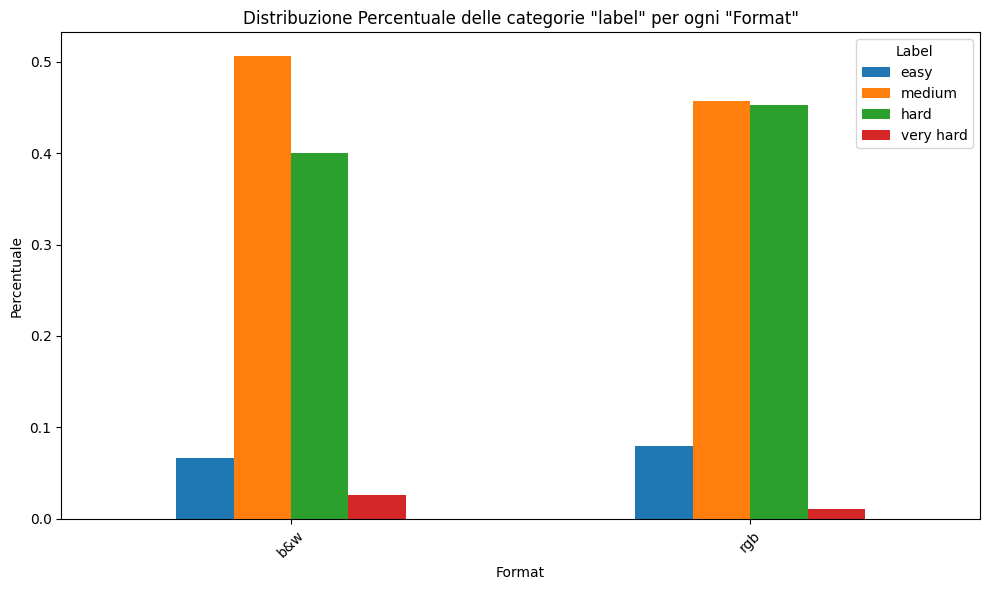

label      easy    medium      hard  very hard
b&w    0.066667  0.506667  0.400000   0.026667
rgb    0.079424  0.456823  0.453092   0.010661


In [ ]:
grouped = df.groupby('Format')['label'].value_counts(normalize=True).unstack(fill_value=0)

# Fase 2: Ordinare i gruppi 'Format' secondo l'ordine definito
grouped.index = pd.Categorical(grouped.index, ordered=True)
grouped = grouped.sort_index()

# Fase 3: Ordinare le categorie 'label' secondo l'ordine definito
grouped = grouped[order_label]

# Fase 4: Creiamo il bar chart con le percentuali
grouped.plot(kind='bar', stacked=False, figsize=(10, 6))

# Fase 5: Aggiungi titolo e etichette
plt.title('Distribuzione Percentuale delle categorie "label" per ogni "Format"')
plt.xlabel('Format')
plt.ylabel('Percentuale')
plt.xticks(rotation=45)  # Ruotiamo le etichette per una lettura migliore
plt.legend(title='Label', loc='upper right')

plt.tight_layout()
plt.show()

print(grouped)